## Exploring the data

Download the Wikipedia dataset + randomly sample sentences as input

In [4]:
# load dataset
from datasets import load_dataset

dataset = load_dataset("wiki_auto")

No config specified, defaulting to: wiki_auto/auto
Reusing dataset wiki_auto (/n/home10/cyeh/.cache/huggingface/datasets/wiki_auto/auto/1.0.0/eeac705719dc9aa2ff180571dfed6c6649588ccdfde8d45a47d2e47e5c5b93af)
100%|██████████| 2/2 [00:16<00:00,  8.21s/it]


In [5]:
# remove data points with no examples
data = [dataset['part_1'][i]['normal']['normal_article_content']['normal_sentence'] for i in range(len(dataset['part_1'])) if len(dataset['part_1'][i]['normal']['normal_article_content']['normal_sentence']) != 0] 

In [6]:
# now see how many data points there are
data_len = len(data)
data_len

124913

In [7]:
# choose 1000 random data points to sample from
import random
num_examples = 1000
random.seed(10) # set seed
indices = random.sample(range(data_len), num_examples)
indices[:10]

[74894, 4270, 56215, 63250, 75771, 1944, 27013, 60631, 106603, 64395]

In [8]:
# get one sentence for each selected data point
sentences = []
for i in indices:
    # get all sentences associated with data point
    sentence_list = data[i]
    sentence = random.choice(sentence_list) # choose random sentence from list
    sentences.append(sentence)

sentences[:10]

['Synthpop band Freezepop have used it on stage.',
 "Plumb was awarded a knighthood in the Queen's Birthday Honours list in 1973.",
 'He read and memorized the entire Quran by the time he was nine years old.',
 "Some other yearly festivals are Paris-Plages, a festive event that lasts from mid-July to mid-August when the Right Bank of the Seine is converted into a temporary beach with sand, deck chairs and palm trees; Journées du Patrimoine, Fête de la Musique, Techno Parade, Nuit Blanche, Cinéma au clair de lune, Printemps des rues, Festival d'automne, and Fête des jardins.",
 'Despite this decision, many Church of the East Old Calendarists rejected the move so in an attempt to avert further dissent, the Holy Synod maintained that Easter would continue to be celebrated according to the Julian Calendar.',
 "On a difficult, slow pitch at Port Elizabeth, Australia struggled their way to 212 (7 wickets, 50 overs) against tight Sri Lankan bowling, thanks mainly to a great innings from A

### archive

In [2]:
# find where sentences are located
dataset['part_1'][0]['normal']['normal_article_content']['normal_sentence']

["Lata Mondal ( ; born: 16 January 1993, Dhaka) is a Bangladeshi cricketer who plays for the Bangladesh national women's cricket team.",
 'She is a right handed batter.',
 'Mondal was born on January 16, 1993 in Dhaka, Bangladesh.',
 "Mondal made her ODI career against the Ireland women's cricket team on November 26, 2011.",
 "Mondal made her T20I career against the Ireland women's cricket team on August 28, 2012.",
 "In October 2018, she was named in Bangladesh's squad for the 2018 ICC Women's World Twenty20 tournament in the West Indies.",
 "Mondal was a member of the team that won a silver medal in cricket against the China national women's cricket team at the 2010 Asian Games in Guangzhou, China."]

In [4]:
# see how many data points there are
data_len = len(dataset['part_1'])
data_len

125059

## Running BERT

Just seeing the basic output from BERT with 2 sentences

In [1]:
# load model
from transformers import BertTokenizer, BertModel

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# adapted from bertviz: github.com/jessevig/bertviz
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "This is a test"
sentence_b = "Hi my name is Catherine"
inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
output = model(input_ids, token_type_ids=token_type_ids)
attention = output[-1]
# sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [92]:
word_embeddings = output[0]
print(word_embeddings.shape)

torch.Size([1, 6, 768])


### query/key weights

In [23]:
# get key + query weights
query_weights = []
key_weights = []

for i in range(12):
    query_weights.append(model.encoder.layer[i].attention.self.query.weight)
    key_weights.append(model.encoder.layer[i].attention.self.key.weight)
    
print(len(query_weights))
print(len(query_weights[0]))
print(len(query_weights[0][:64]))
print(query_weights[0][:64][:64])

12
768
64
tensor([[-0.0164,  0.0261, -0.0263,  ...,  0.0154,  0.0768,  0.0548],
        [-0.0326,  0.0346, -0.0423,  ..., -0.0527,  0.1393,  0.0078],
        [ 0.0105,  0.0334,  0.0109,  ..., -0.0279,  0.0258, -0.0468],
        ...,
        [-0.0186,  0.0482, -0.0724,  ..., -0.0434,  0.0385,  0.0423],
        [-0.0095, -0.0285, -0.0453,  ...,  0.0170,  0.0357, -0.0408],
        [ 0.0112, -0.0349, -0.0304,  ...,  0.0217, -0.0631,  0.0212]],
       grad_fn=<SliceBackward0>)


In [31]:
# get key/query weights for a particular layer and head of BERT
def get_weights(weights, layer): 
    layer_weights = weights[layer]
    start = layer * 64
    end = start + 64
    head_weights = [i[:64].detach().numpy() for i in layer_weights[start:end]] # only use first 64 columns of matrix
    return head_weights

qw = get_weights(query_weights, 0)
kw = get_weights(key_weights, 0)
print(len(qw))
print(len(qw[0]))
# print(qw)
# print(kw)

64
64


In [47]:
# translate queries/keys

new_queries = []
new_keys = []
for layer in range(12):
    qw = get_weights(query_weights, layer)
    kw = get_weights(key_weights, layer)
    
    layer_q = []
    layer_k = []
    for head in range(12):
        residuals = get_residual(layer, head, all_embeddings)
        head_q = []
        head_k = []
        
        for i in range(5021):
            resid = residuals[i]
            pos = pos_embeddings[i]
            
            new_q = (resid - pos) @ qw
            new_k = (resid - pos) @ kw
            
            head_q.append(new_q)
            head_k.append(new_k)
        
        layer_q.append(head_q)
        layer_k.append(head_k)
    new_queries.append(layer_q)
    new_keys.append(layer_k)
        

In [48]:
# testing output
print(len(new_queries))
print(len(new_queries[0]))
print(len(new_queries[0][0]))
print(len(new_queries[0][0][0]))
print(new_queries[0][0][0])

12
12
5021
64
[ 0.08480563  0.24831967 -0.13222303 -0.00308735  0.17955143 -0.28498011
  0.32677824 -0.05216651 -0.32296397  0.10389483 -0.57034313  0.0519156
 -0.02340658  0.16960336 -0.30232361  0.35793962  0.2336314   0.28153966
 -0.28986431 -0.26094894  0.03506478  0.01769213 -0.403072   -0.31568066
  0.03809893 -0.3227444   0.17612359  0.58534131  0.23848697 -0.36905954
  0.15353027  0.01464106 -0.31937563  0.0731942   0.20752022 -0.18858227
 -0.26953675  0.35488188 -0.14051807 -0.35651356 -0.29708777 -0.24629837
 -0.10436783 -0.04787108 -0.19269979  0.06421703 -0.28329213 -0.11571382
  0.30390886 -0.16826329 -0.20846852 -0.02206914  0.16506941 -0.30233688
 -0.03226167 -0.31777684 -0.10512244  0.11753963  0.02489097 -0.54596617
 -0.28825733  0.10587335 -0.35390053  0.42028851]


### archive

In [5]:
# check out parameters
for name, param in model.named_parameters():                
    print(name, param.size())

embeddings.word_embeddings.weight torch.Size([30522, 768])
embeddings.position_embeddings.weight torch.Size([512, 768])
embeddings.token_type_embeddings.weight torch.Size([2, 768])
embeddings.LayerNorm.weight torch.Size([768])
embeddings.LayerNorm.bias torch.Size([768])
encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
encoder.layer.0.attention.self.query.bias torch.Size([768])
encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
encoder.layer.0.attention.self.key.bias torch.Size([768])
encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
encoder.layer.0.attention.self.value.bias torch.Size([768])
encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
encoder.layer.0.attention.output.dense.bias torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
encoder.layer.0.intermediate.dense.weight torch.Size([3072, 768])
encoder.layer.0.inter

In [42]:
print(model.encoder.layer[0].attention.self.query)

torch.Size([768, 768])


In [6]:
print(model.encoder.layer[11].attention.self.query.bias)

Parameter containing:
tensor([ 5.0130e-02,  1.1887e-01,  2.1868e-01,  8.7210e-02, -2.0477e-01,
         2.2648e-01, -3.4360e-01,  6.4057e-02, -4.1554e-01,  1.1557e-01,
         2.8522e-01, -1.0724e-01,  2.1037e-01,  6.5960e-02, -8.9728e-02,
        -6.1263e-02,  1.1344e-01, -1.9265e-01, -1.2109e-02, -2.4905e-01,
         7.1558e-02, -2.0746e-01, -1.8167e-01, -1.9616e-02,  5.7593e-02,
        -4.0425e-02,  3.1487e-01, -1.6641e-01,  3.6615e-01,  2.8458e-02,
        -8.9834e-02, -4.3720e-02, -1.2218e-01,  1.1063e-01,  4.6565e-02,
         5.6489e-02,  2.5875e-01,  1.0859e-01, -2.2724e-01, -1.5846e-01,
        -2.0762e-01, -2.8562e-01, -1.6824e-01,  1.7382e-01,  2.8304e-02,
        -8.5946e-02, -1.2882e-01, -3.9624e-05,  1.3995e-01, -1.4809e-01,
        -1.4983e-01,  8.0181e-02, -2.4638e-01,  1.3984e-01, -4.8627e-01,
        -3.8021e-02,  7.8774e-02, -5.4215e-01,  1.8015e-01, -2.4764e-01,
        -8.2056e-02,  2.0403e-01, -1.2871e-01,  1.7048e-01,  3.3818e-01,
        -5.3207e-01,  2.6975e

In [35]:
print(tokens)
print(len(tokens))
print(len(embeddings)) # num layers
print(len(embeddings[0][0])) # num tokens
print(len(embeddings[0][0][0])) # num tokens
print(embeddings[0][0][0][0]) # num tokens

['[CLS]', 'plum', '##b', 'was', 'awarded', 'a', 'knight', '##hood', 'in', 'the', 'queen', "'", 's', 'birthday', 'honours', 'list', 'in', '1973', '.', '[SEP]']
20
12
12
20
tensor([0.0380, 0.0188, 0.0278, 0.0264, 0.0301, 0.1063, 0.0305, 0.0245, 0.0633,
        0.0966, 0.0320, 0.0324, 0.0258, 0.0352, 0.0172, 0.0413, 0.0653, 0.0295,
        0.0721, 0.1866], grad_fn=<SelectBackward0>)


In [20]:
# check out output
print(sentence_a)
print(sentence_b)
print(tokens)
print(len(tokens))

In the early 1970s, Edgar Winter often performed with keyboards slung around his neck, but they were not technically keytars because they had no "neck"; he actually used an ARP 2600 keyboard and a lightweight Univox electronic piano with shoulder straps added.
As of July 2012, Plumb's entry in the register of interests listed his only remunerated employment/profession as 'farming', despite his involvement with the Brussels-based lobbying firm Alber and Geiger since 2007.
['[CLS]', 'in', 'the', 'early', '1970s', ',', 'edgar', 'winter', 'often', 'performed', 'with', 'keyboards', 'slung', 'around', 'his', 'neck', ',', 'but', 'they', 'were', 'not', 'technically', 'key', '##tar', '##s', 'because', 'they', 'had', 'no', '"', 'neck', '"', ';', 'he', 'actually', 'used', 'an', 'ar', '##p', '260', '##0', 'keyboard', 'and', 'a', 'lightweight', 'un', '##ivo', '##x', 'electronic', 'piano', 'with', 'shoulder', 'straps', 'added', '.', '[SEP]', 'as', 'of', 'july', '2012', ',', 'plum', '##b', "'", 's', 

In [43]:
print(len(attention)) # corresponds to 12 layers of model
print(len(attention[0][0])) # 12 attention heads (e.g., different attention patterns/mechanisms)
print(attention[0][0][0].shape) # size of attention matrix (at each head)

12
12
torch.Size([104, 104])


In [48]:
print(sum(attention[0][0][0][0])) # normalized, attention weights for each token must sum to 1

tensor(1., grad_fn=<AddBackward0>)


## Masking

In [ ]:
from transformers import pipeline
import random
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
unmasker = pipeline('fill-mask', model=model_version)

random.seed(10) # set seed

# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)

new_sentences = []
replaced = []

for sent in sentences:
    encoded = tokenizer(sent, return_tensors='pt')
    tokens = encoded['input_ids'][0]
    num_tokens = len(tokens) - 3 # don't include cls/sep
    mask_ind = random.randint(0, num_tokens) + 1
    old_token = ''.join(tokenizer.decode(tokens[mask_ind]).split(" ")) # save old token
    
    tokens[mask_ind] = 103 # replace randomly selected token with mask

    tokens = tokens[1:-1] # remove extra cls and sep
    new_sent = tokenizer.decode(tokens) # convert back to string
#     results = unmasker(new_sent)
#     final_res = results[0]['sequence'] # new sentence
#     new_token = results[0]['token_str'] # new token
    
#     if old_token == new_token:
#         final_res = results[1]['sequence'] # new sentence
#         new_token = results[1]['token_str'] # new token
#     replaced.append({"index": mask_ind, "old": old_token, "new": new_token}) # save to list
    replaced.append({"index": mask_ind, "old": old_token})
    
    # new_sentences.append(final_res)
    new_sentences.append(new_sent)
    # break
    
print(new_sentences[:10])
print(replaced[:10])

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_version)

for s1, s2 in zip(sentences, new_sentences):
    encoded1 = tokenizer(s1, return_tensors='pt')
    tokens1 = encoded1['input_ids'][0]
    encoded2 = tokenizer(s2, return_tensors='pt')
    tokens2 = encoded2['input_ids'][0]
    if len(tokens1) != len(tokens2):
        # print(tokens1)
        # print(tokens2)
        print(len(tokens1), s1)
        print(len(tokens2), s2)
        print("\n")

In [38]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

## Getting Q, K vectors

Follow Jesse Vig's method of extracting query + key info

In [14]:
# import methods from bertviz
from bertviz import neuron_view
import numpy as np

In [19]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
import random
import string

model_type = 'bert'
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)

sentences_test = sentences[:10] # small sample to test out code with
num_heads = 12
num_layers = 12

# master dictionary for all values
attn_dict = {'left_text': [], 
             'right_text': [], 
             'positions': [],
             'normalized_positions': [],
             'sentences': [],
             'tokenized_sentences': [],
             'queries': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)], 
             'keys': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
             'attn': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
             'dot_prod': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)]}

for s in new_sentences[:10]:
    # call method from bertviz to get attention info
    s_dict = neuron_view.get_attention(model, model_type, tokenizer, s, include_queries_and_keys=True)['all']
    
    # append to master dictionary
    tokens = s_dict['left_text']
    attn_dict['left_text'].extend(tokens)
    attn_dict['right_text'].extend(s_dict['right_text'])
    
    for index in range(len(tokens)): # save position of token and tokenized sentences too
        attn_dict['positions'].append(index)
        attn_dict['normalized_positions'].append(index / (len(tokens) - 1))
        attn_dict['sentences'].append(s)
        attn_dict['tokenized_sentences'].append(' '.join(tokens))
        
    for i in range(num_heads): # updating cumulative q/k vectors + attn
        for j in range(num_layers):
            q = attn_dict['queries'][i][j]
            k = attn_dict['keys'][i][j]
            a = attn_dict['attn'][i][j]
            d = attn_dict['dot_prod'][i][j]
            
            if len(q) == 1: # on first round, need to empty list (random string was placeholder)
                q.clear()
            query = s_dict['queries'][i][j]
            q.extend(query)
            np_query = np.array(query)
            
            if len(k) == 1:
                k.clear()
            key = s_dict['keys'][i][j]
            k.extend(key)
            np_key = np.array(key)
            
            if len(a) == 1:
                a.clear()
            a.extend(s_dict['attn'][i][j])
            
            if len(d) == 1:
                d.clear()
            dp = np.dot(np_query, np_key.transpose())
            d.extend(dp)

In [23]:
# different size for some reason??
print(len(attn_dict['left_text']))
print(attn_dict['positions'][-20:])

30085
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [38]:
import pickle
# save dictionary to pickle file
with open('attn_dict_new.p', 'wb') as file:
    pickle.dump(attn_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

### Trying out attention plot generation

In [14]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer

## NEURON VIEW
model_type = 'bert'
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)

sentence_a = "This is a test"

# generate html for attention view
html = neuron_view.show(model, model_type, tokenizer, sentence_a, sentence_b=None, display_mode='dark', layer=0, head=0, html_action='return')

with open('att.html', "w") as file: # save html to file
    file.write(html.data)

In [20]:
## HEAD VIEW
from transformers import BertTokenizer, BertModel
from bertviz import head_view

model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
# sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

html = head_view(attention, tokens, layer=0, heads=[0], include_layers=[0], html_action='return') # generate html

with open('att2.html', "w") as file: # save html to file
    file.write(html.data)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### checking output

In [10]:
print(len(attn_dict['left_text']))
print(attn_dict['left_text'][:20])

print(len(attn_dict['positions']))
print(attn_dict['positions'][:-20])

print(len(attn_dict['sentences']))
print(attn_dict['sentences'][:20])

print(len(attn_dict['tokenized_sentences']))
print(attn_dict['tokenized_sentences'][:20])

356
['[CLS]', 'synth', '##pop', 'band', 'freeze', '##pop', 'have', 'used', 'it', 'on', 'stage', '.', '[SEP]', '[CLS]', 'plum', '##b', 'was', 'awarded', 'a', 'knight']
356
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 

In [37]:
# checking
print(attn_dict['tokenized_sentences'][0])
print(len(attn_dict['tokenized_sentences'][0].split()))

print("\n" + str(len(attn_dict['attn'])))
print(len(attn_dict['attn'][0]))
print(len(attn_dict['attn'][0][0]))
print(len(attn_dict['attn'][0][0][14]))

[CLS] synth ##pop band freeze ##pop have used it on stage . [SEP]
13

12
12
356
20


In [12]:
print(attn_dict['left_text']) # see output for smaller sample

['[CLS]', 'synth', '##pop', 'band', 'freeze', '##pop', 'have', 'used', 'it', 'on', 'stage', '.', '[SEP]', '[CLS]', 'plum', '##b', 'was', 'awarded', 'a', 'knight', '##hood', 'in', 'the', 'queen', "'", 's', 'birthday', 'honours', 'list', 'in', '1973', '.', '[SEP]', '[CLS]', 'he', 'read', 'and', 'memo', '##rized', 'the', 'entire', 'quran', 'by', 'the', 'time', 'he', 'was', 'nine', 'years', 'old', '.', '[SEP]', '[CLS]', 'some', 'other', 'yearly', 'festivals', 'are', 'paris', '-', 'pl', '##ages', ',', 'a', 'fest', '##ive', 'event', 'that', 'lasts', 'from', 'mid', '-', 'july', 'to', 'mid', '-', 'august', 'when', 'the', 'right', 'bank', 'of', 'the', 'seine', 'is', 'converted', 'into', 'a', 'temporary', 'beach', 'with', 'sand', ',', 'deck', 'chairs', 'and', 'palm', 'trees', ';', 'jo', '##urne', '##es', 'du', 'pat', '##rim', '##oin', '##e', ',', 'fe', '##te', 'de', 'la', 'musique', ',', 'techno', 'parade', ',', 'nu', '##it', 'blanche', ',', 'cinema', 'au', 'clair', 'de', 'lu', '##ne', ',', 'pri

In [13]:
print(attn_dict['queries'][0][0][0])

[0.7089897394180298, -0.15323276817798615, -0.032386213541030884, 0.6158232092857361, -0.5596219897270203, -0.011101782321929932, 0.49646368622779846, -0.2839057445526123, -0.280123233795166, 0.3392143249511719, -0.29341602325439453, -0.17901477217674255, 0.8661503195762634, 0.022664345800876617, 0.7185714244842529, 0.34335076808929443, 0.01236235722899437, 0.7172088027000427, 0.32118237018585205, -2.046285629272461, -0.45574820041656494, 0.1372668296098709, 0.7596356868743896, 0.7640693187713623, -0.485566645860672, -0.5769205093383789, 0.25511786341667175, 1.1232143640518188, 0.29362547397613525, 1.985978364944458, 0.7019451856613159, -0.509594202041626, 0.6935110688209534, 0.03461742401123047, 0.2705886960029602, -0.9227743148803711, 0.2610951066017151, -0.030122220516204834, 0.5660263895988464, -0.2227349430322647, -0.168127179145813, -0.7366577386856079, 0.3504031300544739, 0.6493116617202759, -1.475498080253601, -0.19565290212631226, 0.21594813466072083, -0.4464242160320282, -0.1

In [14]:
# checking to make sure things look right
print(len(attn_dict['left_text'])) # num tokens
      
print(len(attn_dict['queries'])) # 12 layers
print(len(attn_dict['queries'][0])) # 12 heads
print(len(attn_dict['queries'][0][0])) # source sequence length (number of tokens)
print(len(attn_dict['queries'][0][0][0])) # vector size

195
12
12
195
64


In [15]:
print(len(attn_dict['right_text'])) # num tokens
      
print(len(attn_dict['keys'])) # 12 layers
print(len(attn_dict['keys'][0])) # 12 heads
print(len(attn_dict['keys'][0][0])) # source sequence length (number of tokens)
print(len(attn_dict['keys'][0][0][0])) # vector size

195
12
12
195
64


### archive

In [11]:
# this output does include query and key vectors
output = model(input_ids, token_type_ids=token_type_ids)

In [103]:
"""
from bertviz documentation:
    get_attention method should return:
      Dictionary of attn representations with the structure:
      {
        'all': All attention (source = AB, target = AB)
        'aa': Sentence A self-attention (source = A, target = A) (if sentence_b is not None)
        'bb': Sentence B self-attention (source = B, target = B) (if sentence_b is not None)
        'ab': Sentence A -> Sentence B attention (source = A, target = B) (if sentence_b is not None)
        'ba': Sentence B -> Sentence A attention (source = B, target = A) (if sentence_b is not None)
      }
      where each value is a dictionary:
      {
        'left_text': list of source tokens, to be displayed on the left of the vis
        'right_text': list of target tokens, to be displayed on the right of the vis
        'attn': list of attention matrices, one for each layer. Each has shape [num_heads, source_seq_len, target_seq_len]
        'queries' (optional): list of query vector arrays, one for each layer. Each has shape (num_heads, source_seq_len, vector_size)
        'keys' (optional): list of key vector arrays, one for each layer. Each has shape (num_heads, target_seq_len, vector_size)
      }
"""
print(len(attn_dict))

4


## Context Embeddings

In [110]:
# adapted from bertviz: github.com/jessevig/bertviz
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

all_embeddings = []

for sent in sentences:
    inputs = tokenizer.encode_plus(sent, return_tensors='pt')
    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    output = model(input_ids, token_type_ids=token_type_ids)
    embeddings = output[0]
    for e in embeddings[0]:
        all_embeddings.append(e)
    
    # break
    
print(len(all_embeddings))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


30070


In [111]:
all_embeddings = all_embeddings[:5021] # only take first 5021 tokens
print(len(all_embeddings))

5021


### archive

In [ ]:
!pip install flair

In [85]:
from flair.data import Sentence
from flair.embeddings import BertEmbeddings
bert_embedding = BertEmbeddings()

embeddings = []

for sent in sentences:
    s = Sentence(sent)
    bert_embedding.embed(s)
    for token in s:
       embeddings.append(token.embedding)
    # break
    
print(len(embeddings))

<ipython-input-85-8cf289f84c96>:3: DeprecationWarning:

Call to deprecated method __init__. (Use 'TransformerWordEmbeddings' for all transformer-based word embeddings) -- Deprecated since version 0.4.5.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

24592


## Residuals

In [9]:
# adapted from bertviz: github.com/jessevig/bertviz
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

all_embeddings = [[] for i in range(12)]

for sent in sentences:
    inputs = tokenizer.encode_plus(sent, return_tensors='pt')
    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    output = model(input_ids, token_type_ids=token_type_ids)
    
    hidden_states = output[2][:-1]
    num_tokens = len(hidden_states[0][0])
    
    for layer in range(12):
        for token in range(num_tokens):
            all_embeddings[layer].append(hidden_states[layer][0][token])
    
    # break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# get residual for specific layer & head
def get_residual(layer, head, residuals):
    r_layer = residuals[layer]
    # each residual is 768 dimensions, so find the 64 that correspond to the selected attention head
    start_ind = head * 64 
    end_ind = start_ind + 64
    
    r_final = [i[start_ind:end_ind].detach().numpy() for i in r_layer]
    r_final = r_final[:5021] * 2 # only get first X keys + queries
    return r_final

resids = get_residual(0, 0, all_embeddings)
print(len(resids))
print(len(resids[0]))
print(resids[0])

10042
64
[ 1.68550611e-01 -2.85767347e-01 -3.26125652e-01 -1.12221323e-01
  3.42655107e-02 -2.68935174e-01 -3.01621370e-02 -3.90163623e-02
  1.56526677e-02 -2.82755405e-01  1.43631563e-01  4.25704345e-02
 -2.20335647e-01 -2.25466071e-03 -5.52473664e-01  1.09220691e-01
 -2.10745521e-02 -1.50729027e-02  7.24183619e-02 -3.03359687e-01
 -2.24982277e-01 -3.32935095e-01 -9.43784043e-02  1.07110158e-01
 -1.35721669e-01 -2.33887285e-01 -1.06749043e-01  1.03951305e-01
 -6.77929223e-02  3.17846909e-02 -1.96523279e-01 -2.63706665e-03
 -2.81366557e-01  4.35710959e-02 -9.46923122e-02 -1.96458235e-01
 -1.09173775e-01  1.35144338e-01  1.40180349e-01  3.25616807e-01
 -2.39917673e-02 -3.05968896e-02 -7.73773193e-02 -9.79134142e-02
 -1.20807745e-01 -3.53562199e-02 -3.93704987e+00  2.23355517e-02
  4.69372094e-01 -2.01446369e-01  7.13367939e-01  1.69042498e-01
 -4.30158138e-01  1.16221440e+00  4.00428563e-01 -1.14218384e-01
 -1.30139068e-01 -1.06879704e-01  1.31391615e-01 -3.66064578e-01
  3.23308678e-03

## Positional Encodings

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# compute position encoding for some token
def getPositionEncoding(k, d=64, n=10000):
    P = np.zeros(d)
    for i in np.arange(int(d/2)):
        denominator = np.power(n, 2*i/d)
        # no noise
        P[2*i] = np.sin(k/denominator)
        P[2*i+1] = np.cos(k/denominator)
        # # or, add some random noise too
        # P[2*i] = np.sin(k/denominator) + np.random.normal(0,0.001)
        # P[2*i+1] = np.cos(k/denominator) + np.random.normal(0,0.001)
    return P

for i in range(4):
    P = getPositionEncoding(k=i)
    print(P)

[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
[8.41470985e-01 5.40302306e-01 6.81561350e-01 7.31760976e-01
 5.33168440e-01 8.46009110e-01 4.09308924e-01 9.12395860e-01
 3.10983593e-01 9.50415280e-01 2.34921076e-01 9.72014449e-01
 1.76892186e-01 9.84230234e-01 1.32957266e-01 9.91121771e-01
 9.98334166e-02 9.95004165e-01 7.49191579e-02 9.97189611e-01
 5.62044992e-02 9.98419278e-01 4.21571532e-02 9.99110992e-01
 3.16175064e-02 9.99500042e-01 2.37115146e-02 9.99718843e-01
 1.77818569e-02 9.99841890e-01 1.33348191e-02 9.99911087e-01
 9.99983333e-03 9.99950000e-01 7.49887181e-03 9.99971883e-01
 5.62338361e-03 9.99984189e-01 4.21695254e-03 9.99991109e-01
 3.16227239e-03 9.99995000e-01 2.37137148e-03 9.99997188e-01
 1.77827847e-03 9.99998419e-01 1.33352104e-03 9.99999111e-01
 9.99999833e-04 9.99999500e-01 7.49894139e-04 9.99999719e-01
 5.62341296

In [36]:
pos_embeddings = []
for ind in zip(attn_dict["positions"][:5021]):
    P = getPositionEncoding(k=ind)
    pos_embeddings.append(P)

In [37]:
pos_embeddings += pos_embeddings
print(len(pos_embeddings))

10042


In [50]:
# run TSNE on position embeddings
def run_pos_tsne(df):
    # run TSNE
    # from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    time_start = time.time()
    # tsne = TSNE(n_components=3, verbose=0, perplexity=100, n_iter=300) # 3D
    tsne = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=300) # 2D
    tsne_results = tsne.fit_transform(df)
    np.save("tsne/position_short.npy", tsne_results) # save tsne results too
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results

tsne_results = run_pos_tsne(pos_embeddings)

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 15.35981297492981 seconds


In [51]:
def run_pos_umap(df):
    # run umap
    time_start = time.time()
    umap = UMAP(n_components=2, init='random', random_state=0)
    umap_results = umap.fit_transform(df)
    np.save("umap/position_short.npy", umap_results) # save umap results too
    print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return umap_results

umap_results = run_pos_umap(pos_embeddings)

UMAP done! Time elapsed: 8.58793592453003 seconds


## Distances

### translate keys

In [59]:
queries = attn_dict["queries"]
keys = attn_dict["keys"]

print(len(queries))
print(len(queries[0]))
print(len(queries[0][0]))
print(len(queries[0][0][0]))

12
12
30070
64


In [11]:
# get means
mean_queries = []
mean_keys = []
for layer in range(12):
    for head in range(12):
        q = queries[layer][head]
        k = keys[layer][head]
        num_tokens = len(q)
        mean_q = [0] * 64
        mean_k = [0] * 64
        for i in range(num_tokens):
            for j in range(64):
                q_token = q[i]
                k_token = k[i]
                mean_q[j] += q_token[j]
                mean_k[j] += k_token[j]
        
        mean_q = [i / num_tokens for i in mean_q]
        mean_k = [i / num_tokens for i in mean_k]
        mean_queries.append(mean_q)
        mean_keys.append(mean_k)
    #     break
    # break

In [8]:
print(mean_queries[0])
print(mean_keys[0])

[0.6713209990769798, -0.3504800015185208, -0.2755414847712586, 0.2920304079623388, -1.4983119962691744, -0.2642570830020037, 0.02573924034856827, 0.29150497891051597, 0.16294850382370374, 0.16900758536047503, 0.23691737587804654, 0.3870285762715831, 0.0024249803283774318, 0.1974163256030583, 0.2768431144469025, 0.38220289008683234, 0.004181497222833746, -0.44090031703550137, -0.39226237612460235, -2.2678035543757664, -0.08923760628743176, 0.06590045038572756, 0.1854289023681907, 0.20524004427753303, 0.0008387157994319071, 0.23076008947949891, 0.10858334998276839, 0.343707907589067, -0.0964303148432508, -0.9084981572489856, 0.04483407792028369, -0.12484885898344703, -0.07322577819863714, -0.09847368502704161, -0.17016701815841273, 0.06140910939354974, -0.042458051760646286, -0.16751931794561503, 0.258347463994208, -0.13985757336366114, -0.1750012412294219, -0.10044270749860464, -0.5890128850728139, -1.2656078146758827, -0.4031883520513214, -1.7811532410564743, 0.08796154294783354, 0.048

In [12]:
# fix key means
new_mean_keys = []
for layer in range(12):
    for head in range(12):
        mean_k = [0] * 64
        k = keys[layer][head]
        m_k = mean_keys[12 * layer + head]
        q_k = mean_queries[12 * layer + head]
        num_tokens = len(k)
        for i in range(num_tokens):
            k_token = k[i]
            for j in range(64):
                orig_k = k_token[j]
                k_token[j] = orig_k - m_k[j] + q_k[j]  
                mean_k[j] += k_token[j]
        
        mean_k = [i / num_tokens for i in mean_k]
        new_mean_keys.append(mean_k)

In [9]:
print(new_mean_keys[0])

[0.6713567556312006, -0.35049525003940113, -0.27555298880061063, 0.29204354541523425, -1.4983012863666416, -0.264246229301856, 0.025740481565031004, 0.2915168468212491, 0.16296225071647802, 0.16901534626855227, 0.2369123767504801, 0.387047982523841, 0.002425512736395818, 0.1974270200657288, 0.2768692114151126, 0.38222153722362856, 0.004185313063846823, -0.4408793642969245, -0.39227626701420676, -2.267782116924903, -0.08924455205291788, 0.06590203722581511, 0.18543566548405963, 0.2052582376021477, 0.0008382849282315172, 0.23076759973303665, 0.10858442076361155, 0.3437398181527278, -0.09643860357068135, -0.9085103906163622, 0.04484070714428891, -0.12485395813705243, -0.07323603077756397, -0.09847564135592136, -0.17016880008619192, 0.06141565335507736, -0.042464015572097086, -0.16752610107999988, 0.2583630757769539, -0.13986024104248024, -0.1750112729146886, -0.1004642229872737, -0.5890263063149676, -1.2656241276757856, -0.4032213607128503, -1.7811787988677463, 0.08795748653228522, 0.0483

#### Comparing embeddings

In [62]:
## compute cosine similarity instead...
import numpy as np
from numpy.linalg import norm

similarities = []
for layer in range(12):
    for head in range(12):
        sim = []
        qs = queries[layer][head]
        ks = keys[layer][head]
        num_tokens = len(qs)
        for i in range(num_tokens):
            q = qs[i]
            k = ks[i]
            cosine = np.dot(q, k) / (norm(q) * norm(k))
            sim.append(cosine)
        similarities.append(sim)

In [66]:
## mean similiarties
mean_similarities = []
for layer in range(12):
    for head in range(12):
        sim = similarities[layer * 12 + head]
        lh_mean = sum(sim) / len(sim)
        mean_similarities.append(lh_mean)

In [77]:
import math
min_diff = min(mean_similarities)
min_i = mean_similarities.index(min_diff)
min_head = math.floor(min_i / 12)
min_layer = min_i % 12
max_diff = max(mean_similarities)
max_i = mean_similarities.index(max_diff)
max_head = math.floor(max_i / 12)
max_layer = max_i % 12

mean_sim = sum(mean_similarities) / len(mean_similarities)
print("mean: {}".format(mean_sim))
print("min: {} (head {}, layer {})".format(min_diff, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_diff, max_head, max_layer))

abs_means = [abs(i) for i in mean_similarities]

min_diff = min(abs_means)
min_i = abs_means.index(min_diff)
min_head = math.floor(min_i / 12)
min_layer = min_i % 12
max_diff = max(abs_means)
max_i = abs_means.index(max_diff)
max_head = math.floor(max_i / 12)
max_layer = max_i % 12

mean_sim = sum(mean_similarities) / len(mean_similarities)
print("mean: {}".format(mean_sim))
print("min: {} (head {}, layer {})".format(min_diff, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_diff, max_head, max_layer))

mean: 0.16349905106915127
min: -0.2811459266089006 (head 10, layer 3)
max: 0.6227503914777436 (head 3, layer 0)
mean: 0.16349905106915127
min: 0.000705366328767812 (head 11, layer 3)
max: 0.6227503914777436 (head 3, layer 0)


##### archive

In [16]:
mean_differences = []
for layer in range(12):
    for head in range(12):
        q = queries[layer][head]
        k = keys[layer][head]
        num_tokens = len(k)
        diff = [0] * 64
        for i in range(num_tokens):
            k_token = k[i]
            q_token = q[i]
            for j in range(64):
                d = abs(k_token[j] - q_token[j])
                diff[j] += d
        diff = [i / num_tokens for i in diff]
        mean_differences.append(diff)

In [21]:
print(mean_differences[0])

[0.8268128663122672, 0.6226537862345035, 0.5852452831607249, 0.6464337632283559, 0.7832672869839302, 0.7922298509176053, 0.6366632568679528, 0.6586314986186363, 0.6405394505020497, 0.741457755014172, 0.68849741964895, 0.7070176195792275, 0.5365770969849393, 0.6423258942395844, 0.6273367967853686, 0.6132491899099455, 0.6744871832199678, 0.6571061986971025, 0.9628479255087602, 0.6965897124836499, 0.6226675727810352, 0.6294952143193489, 0.7121953966172683, 0.5555478792424953, 0.540911566248694, 0.5925841440478156, 0.6214005057683301, 0.7553408544257931, 0.6042256422528801, 0.9876724796509325, 0.6605743499755085, 0.6493723623433048, 0.7382299153032593, 0.6108495712537841, 0.6243845757884855, 0.6315117459618603, 0.6255038550743456, 0.6476341747612361, 0.610109206713969, 0.5799336650753363, 0.6397163875146765, 0.6065093569537594, 0.7595661024482384, 0.7748550822417616, 0.682409857583248, 0.6132499417720592, 0.6919862534316785, 0.6910362254897983, 0.6309314390449428, 0.6983915182550039, 0.661

In [31]:
# find mean diff for each layer/head combo
mean_overall = []
for m in mean_differences:
    mean_overall.append(sum(m) / len(m))
    
print(mean_overall)

[0.673053909536601, 0.8403980746731862, 1.0272211441549803, 0.9444726357821988, 0.7600437919211681, 0.8287684100610213, 0.6375711379127551, 0.8073411545235744, 0.779097147250187, 0.776832132602526, 1.0478538979896008, 0.9761206689708188, 0.9181026998610037, 1.2070932054639871, 0.8864706175424273, 0.8041414508884956, 1.1656432323520416, 0.930418671712135, 0.9656471187452393, 0.8242588567503666, 0.9307567854366459, 0.9649982605309194, 0.9363908185136316, 0.7592497860061089, 1.532860898285362, 1.208181033575878, 0.9759601680798118, 0.9792583438232467, 0.8969237687342123, 0.8574558029680994, 0.6705675463010237, 0.9425833694171943, 0.9732260159304356, 1.542865139320017, 0.8893899150332566, 0.8988810609406994, 0.7633280831724337, 0.8870273013232111, 0.85587598041859, 0.9979095345963123, 0.8797057450463239, 1.1840074191694876, 0.8935350579635416, 0.867161614630995, 0.9171275848753436, 1.1296327021359283, 1.0345469134860854, 0.9748756009275305, 0.9549975608829853, 0.8261433710589291, 0.9691408

In [34]:
import math

In [36]:
min_diff = min(mean_overall)
min_i = mean_overall.index(min_diff)
print(min_i)
min_head = math.floor(min_i / 12)
min_layer = min_i % 12
max_diff = max(mean_overall)
max_i = mean_overall.index(max_diff)
print(max_i)
max_head = math.floor(max_i / 12)
max_layer = max_i % 12
print("min: {} (head {}, layer {})".format(min_norm, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_norm, max_head, max_layer))

129
33
min: 0.6237281308150402 (head 10, layer 9)
max: 1.542865139320017 (head 2, layer 9)


##### norms

In [22]:
from numpy import linalg as LA

In [ ]:
## norms
norms = []
for m in mean_differences:
    n = LA.norm(m)
    norms.append(n)
    
print(norms)

[5.433758806543905, 6.8871638647950135, 8.261376610633029, 7.612592030887675, 6.166415670643604, 6.776615576061078, 5.612820190705164, 6.51461618787806, 6.33805277102629, 6.267132756640518, 8.416120938034792, 7.895510430466376, 7.4241228838307896, 9.72023054100175, 7.198392096752991, 6.488339512776655, 9.370791770089873, 7.472620256377382, 7.9594756643475435, 6.622213478314561, 7.473774133654072, 7.7546644526417055, 7.51712123280289, 6.336133034865296, 12.380020147338866, 9.756522536077423, 7.868280683458126, 7.848650478804769, 7.251320813960099, 7.011972883374959, 5.487238435935669, 7.566566307604185, 7.831941217429113, 12.467035799569976, 7.294473869701079, 7.215843164359565, 6.3173158754901575, 7.130702838685068, 6.944227771821316, 8.010093713198351, 7.113041519361209, 9.522499758894632, 7.242285384475088, 6.9934139372847275, 7.4749835933661455, 9.08216371549283, 8.323162719913142, 7.8637673420608145, 7.696767512787849, 6.66649742766423, 7.792992287687199, 6.885769014660629, 7.35293

In [29]:
min_norm = min(norms)
min_i = norms.index(min_norm)
min_head = int(min_i / 12)
min_layer = min_i % 12
max_norm = max(norms)
max_i = norms.index(max_norm)
max_head = int(max_i / 12)
max_layer = max_i % 12
print("min: {} (head {}, layer {})".format(min_norm, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_norm, max_head, max_layer))

min: 5.0948559834162275 (head 10, layer 9)
max: 12.467035799569976 (head 2, layer 9)


In [ ]:
mean_overall = [0] * 64
num_heads = len(mean_differences)
for layer in range(12):
    for head in range(12):
        m = mean_differences[12 * layer + head]
        for i in range(64):
            mean_overall[i] += m[i]

mean_overall = [i / num_heads for i in mean_overall]

In [ ]:
print(mean_overall)

[0.9427429704082518, 0.9294392021432655, 0.9500772063278013, 0.9425211919712206, 0.9349626780843211, 0.9349597962042228, 0.9561069467123462, 0.9517443534957957, 0.938715438299845, 0.9541181404198333, 0.936340432180914, 0.9355454568319862, 0.9503824056012837, 0.9451788363394102, 0.9423751002063361, 0.9469132144635848, 0.9420594693010842, 0.9494632888225747, 0.9260914345603636, 0.9427782976654107, 0.9553678269567895, 0.9371840585462681, 0.9391139341831587, 0.9352366025207284, 0.9465226157709012, 0.9530694096010682, 0.9358868041978171, 0.9365199968571676, 0.954988718732689, 0.9434845267239543, 0.9372204071729251, 0.9363926782048524, 0.9331326674529126, 0.9262604947055271, 0.9395805938779124, 0.9236323565652911, 0.9706137780048613, 0.9239282037998043, 0.9503602427607419, 0.9404909022764516, 0.9332247077103517, 0.940216567780475, 0.9463192379764779, 0.9401842737885817, 0.9409387885493925, 0.9344116110675529, 0.9562216439838352, 0.9513143819485825, 0.9484370320188239, 0.9483855418430129, 0.9

### getting distances

In [11]:
from scipy.spatial import distance

In [12]:
# compute distance b/t key and query
# queries = attn_dict["queries"]
# keys = attn_dict["keys"]
sentences = attn_dict["tokenized_sentences"]
num_tokens = len(sentences)

def get_distances(layer, head):
    distances = []

    offset = 0
    while offset < num_tokens:
        s = sentences[offset] # get new sentence
        l = len(s.split(" ")) # length of sentence
        for i in range(l): 
            dists = []
            q = queries[layer][head][offset + i] # iterate through all queries in sentence
            for j in range(l): # and keys
                k = keys[layer][head][offset + j]
                d = distance.cosine(q, k)
                dists.append(d)
            distances.append(dists)
        offset += l
    return distances

distances = get_distances(0, 0)
print(len(distances))

30070


In [13]:
all_dists = []
for layer in range(12):
    layer_dists = []
    for head in range(12):
        head_dists = get_distances(layer, head)
        layer_dists.append(head_dists)
        print("layer {}, head {} done".format(layer, head))
    all_dists.append(layer_dists)        

layer 0, head 0 done
layer 0, head 1 done
layer 0, head 2 done
layer 0, head 3 done
layer 0, head 4 done
layer 0, head 5 done
layer 0, head 6 done
layer 0, head 7 done
layer 0, head 8 done
layer 0, head 9 done
layer 0, head 10 done
layer 0, head 11 done
layer 1, head 0 done
layer 1, head 1 done
layer 1, head 2 done
layer 1, head 3 done
layer 1, head 4 done
layer 1, head 5 done
layer 1, head 6 done
layer 1, head 7 done
layer 1, head 8 done
layer 1, head 9 done
layer 1, head 10 done
layer 1, head 11 done
layer 2, head 0 done
layer 2, head 1 done
layer 2, head 2 done
layer 2, head 3 done
layer 2, head 4 done
layer 2, head 5 done
layer 2, head 6 done
layer 2, head 7 done
layer 2, head 8 done
layer 2, head 9 done
layer 2, head 10 done
layer 2, head 11 done
layer 3, head 0 done
layer 3, head 1 done
layer 3, head 2 done
layer 3, head 3 done
layer 3, head 4 done
layer 3, head 5 done
layer 3, head 6 done
layer 3, head 7 done
layer 3, head 8 done
layer 3, head 9 done
layer 3, head 10 done
layer 

In [14]:
with open('dists.p', 'wb') as file:
    pickle.dump(all_dists, file, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
qk_dict = {"queries": queries, "keys": keys}
with open('qk_dict.p', 'wb') as file:
    pickle.dump(qk_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

### correlation b/t distance and attention

In [1]:
import pickle
# load distances back
distances = pickle.load( open( "dists.p", "rb" ) )

In [3]:
# checking output
print(len(distances)) # layers
print(len(distances[0])) # heads
print(len(distances[0][0])) # all distances for layer 0, head 0
print(len(distances[0][0][0]))
print(distances[0][0][0][0])

12
12
30070
13
0.8178294765716088


In [4]:
attention = attn_dict["attn"]
print(len(attention))
print(len(attention[0]))
print(len(attention[0][0]))
print(len(attention[0][0][0]))
print(attention[0][0][:13])

12
12
30070
13
[[0.05381803959608078, 0.021168988198041916, 0.03471013903617859, 0.043170131742954254, 0.0475354865193367, 0.040170129388570786, 0.0686521828174591, 0.05405007302761078, 0.08710134029388428, 0.11029218882322311, 0.06438088417053223, 0.11712279170751572, 0.2578275203704834], [0.028228582814335823, 0.07439642399549484, 0.10420870035886765, 0.1130404844880104, 0.10648496448993683, 0.10997577756643295, 0.052801452577114105, 0.08969974517822266, 0.03845740854740143, 0.01870766282081604, 0.1136057898402214, 0.03798844292759895, 0.11240451782941818], [0.04920634999871254, 0.224695086479187, 0.08558039367198944, 0.12538334727287292, 0.06627988815307617, 0.08663680404424667, 0.04623511806130409, 0.045876141637563705, 0.03813866153359413, 0.030672550201416016, 0.10548794269561768, 0.027460690587759018, 0.06834705173969269], [0.016744719818234444, 0.28227630257606506, 0.12029682844877243, 0.07438699156045914, 0.07455112785100937, 0.11621305346488953, 0.05436047166585922, 0.0720855

In [5]:
from scipy import stats
import time

In [6]:
correlation = []
for layer in range(12):
    for head in range(12):
        a = attention[layer][head][:5021]
        d = distances[layer][head][:5021]
        num_tokens = len(a)
        lh_cor = []
        offset = 0
        # start = time.time()
        while offset < num_tokens:
            sent_length = len(a[offset])
            s_cor = []
            for i in range(sent_length):
                a_matrix = a[offset + i]
                d_matrix = d[offset + i]
                c = stats.spearmanr(a_matrix, d_matrix)[0]
                s_cor.append(c)
            lh_cor.append(s_cor)
            offset += sent_length
        # print("time: {}".format(time.time() - start))
        correlation.append(lh_cor) 
        # print("layer {}, head {} done".format(layer, head))
    #     break
    # break

In [7]:
print(len(correlation))
print(len(correlation[0]))
print(correlation[0][0])

144
166
[-0.9835164835164836, -0.8516483516483516, -0.8956043956043955, -0.9505494505494506, -0.8131868131868131, -0.901098901098901, -0.5, -0.7142857142857143, 0.09890109890109891, -0.46703296703296704, -0.9230769230769231, -0.532967032967033, -0.6868131868131868]


In [8]:
## get mean per sentence
mean_cor = []
for layer in range(12):
    for head in range(12):
        lh_mean = []
        cor = correlation[layer * 12 + head]
        for sent in cor:
            sent_mean = sum(sent) / len(sent)
            lh_mean.append(sent_mean)
        mean_cor.append(lh_mean)

In [9]:
print(len(mean_cor))
print(len(mean_cor[0]))
print(mean_cor[0])

144
166
[-0.7016060862214709, -0.839172932330827, -0.8037857802400739, -0.9153220516856879, -0.8535460311358829, -0.8474797293807779, -0.8562122031564975, -0.8311069882498453, -0.8891679748822607, -0.7647619047619046, -0.8254425158962021, -0.8216923076923078, -0.8804996712689019, -0.8105434782608696, -0.8682232049947973, -0.776167827416341, -0.8663997033741194, -0.8664936562860438, -0.8984463620158808, -0.8893710259494759, -0.7715614981624833, -0.8393085598441157, -0.8866877329444176, -0.8386186264308011, -0.8189158016147635, -0.8464347491831637, -0.9136110122226178, -0.8389199733073252, -0.8739393939393938, -0.8679782442423731, -0.8942857142857144, -0.8545249217185976, -0.7864962076784735, -0.8407487170087974, -0.8046811308349768, -0.7239995413370027, -0.7924186123683734, -0.7943014705882352, -0.9116659255024032, -0.8043802316248136, -0.8740501150427967, -0.8561134235171699, -0.8374775197435296, -0.7998301341939865, -0.8181818181818183, -0.8532295271049597, -0.8883454734651409, -0.816

In [10]:
## get mean per head
mean_by_head = []
for layer in range(12):
    for head in range(12):
        lh_mean = mean_cor[layer * 12 + head]
        head_mean = sum(lh_mean) / len(lh_mean)
        mean_by_head.append(head_mean)

In [11]:
## overall mean
total_sum = 0
min_mean = 10
min_layer = [0, 0]
max_mean = -10
max_layer = [0, 0]
for layer in range(12):
    for head in range(12):
        head_mean = mean_by_head[layer * 12 + head]
        print("layer {}, head {} mean: {}".format(layer, head, head_mean))
        total_sum += head_mean
        
        if head_mean < min_mean:
            min_mean = head_mean
            min_layer = [layer, head]
        if head_mean > max_mean:
            max_mean = head_mean
            max_layer = [layer, head]
        
total_mean = total_sum / 144
print("overall mean: {}".format(total_mean))
print("min mean: {} (layer {}, head {})".format(min_mean, min_layer[0], min_layer[1]))
print("min mean: {} (layer {}, head {})".format(max_mean, max_layer[0], max_layer[1]))

layer 0, head 0 mean: -0.8429081613038585
layer 0, head 1 mean: -0.9427129846516569
layer 0, head 2 mean: -0.9605522935659704
layer 0, head 3 mean: -0.9806120542548438
layer 0, head 4 mean: -0.9663539510189354
layer 0, head 5 mean: -0.869608562125762
layer 0, head 6 mean: -0.9773984390379847
layer 0, head 7 mean: -0.9419586768572054
layer 0, head 8 mean: -0.9528568398893358
layer 0, head 9 mean: -0.8835817521102302
layer 0, head 10 mean: -0.9752619736440438
layer 0, head 11 mean: -0.905023842211485
layer 1, head 0 mean: -0.905447588770853
layer 1, head 1 mean: -0.9758060165686883
layer 1, head 2 mean: -0.83735036119338
layer 1, head 3 mean: -0.8894613562360405
layer 1, head 4 mean: -0.9760097383349634
layer 1, head 5 mean: -0.9251280010337186
layer 1, head 6 mean: -0.9410335938189948
layer 1, head 7 mean: -0.9287390496540224
layer 1, head 8 mean: -0.8557199593899762
layer 1, head 9 mean: -0.9273392254271348
layer 1, head 10 mean: -0.9300832442319571
layer 1, head 11 mean: -0.9705696738

### distance vs. attention scatterplot

In [32]:
import random

In [41]:
# find mean distance and attention per att head
mean_distances = []
mean_attn = []
random_token = []

random.seed(10)

for layer in range(12):
    for head in range(12):
        a = attention[layer][head][:5021]
        d = distances[layer][head][:5021]
        num_tokens = len(a)
        lh_d = []
        lh_a = []
        offset = 0
        s = 0
        while offset < num_tokens:
            sent_length = len(a[offset])
            # if len(random_token) < 166:
            #     t = random.randint(offset, offset + sent_length - 1)
            #     random_token.append(t)
            # else:
            #     t = random_token[s]
            # a_matrix = a[t]
            # d_matrix = d[t]
            # lh_d.append(sum(a_matrix) / len(a_matrix))
            # lh_a.append(sum(d_matrix) / len(d_matrix))
            s_d = []
            s_a = []
            for i in range(sent_length):
                a_matrix = a[offset + i]
                d_matrix = d[offset + i]
                s_a.append(sum(a_matrix) / len(a_matrix))
                s_d.append(sum(d_matrix) / len(d_matrix))
            lh_d.append(s_d)
            lh_a.append(s_a)
            offset += sent_length
            s += 1
        mean_distances.append(lh_d) 
        mean_attn.append(lh_a) 

In [42]:
print(len(mean_distances))
print(len(mean_distances[0]))
print(len(mean_attn))
print(len(mean_attn[0]))

144
166
144
166


In [17]:
sentence_mean_dists = []
sentence_mean_attn = []
for layer in range(12):
    for head in range(12):
        a = mean_attn[layer * 12 + head]
        d = mean_distances[layer * 12 + head]
        num_sents = len(a)
        lh_d = []
        lh_a = []
        for i in range(num_sents):
            s_a = sum(a[i]) / len(a[i])
            s_d = sum(d[i]) / len(d[i])
            lh_d.append(s_d)
            lh_a.append(s_a)
        sentence_mean_dists.append(lh_d) 
        sentence_mean_attn.append(lh_a) 

In [21]:
print(len(sentence_mean_dists))
print(len(sentence_mean_dists[0]))
print(sentence_mean_dists[0])
print(len(sentence_mean_attn))
print(len(sentence_mean_attn[0]))
print(sentence_mean_attn[0])

144
166
[0.5847615962926468, 0.5746633862543261, 0.5555345061570586, 0.6099863995529138, 0.5520257153104969, 0.5613366848470601, 0.5622641069855462, 0.5834474726398133, 0.5979661865940534, 0.5520332557908784, 0.5693660944430857, 0.5667347756698488, 0.6080066461363275, 0.5367047759260808, 0.5643771139303607, 0.5503925816407736, 0.5536433003553279, 0.5649346879706755, 0.5737865472072712, 0.5679101473999857, 0.5402515469199944, 0.5629417592953083, 0.5857271992887788, 0.5654881609086518, 0.5362246832187173, 0.5678700322149703, 0.58764834278741, 0.5807229104972721, 0.6123278431987775, 0.5562833325002439, 0.5586267772365099, 0.5882575664598627, 0.5405722863011606, 0.5641148583375606, 0.5706830429281489, 0.5193194104849272, 0.5515147896368389, 0.5532793442662144, 0.5900968943420791, 0.579861008455506, 0.5807450169450823, 0.5655154287519434, 0.5700188981317831, 0.5554685661091907, 0.6045452231448672, 0.5755493816062819, 0.6024758956928079, 0.5541123154705488, 0.5912009207896239, 0.551478554807

In [39]:
cor2 = []
for i in range(144):
    a = mean_attn[i]
    d = mean_distances[i]
    cor2.append(stats.spearmanr(a, d)[0])
    
print(cor2)
print(sum(cor2) / len(cor2))

[-0.11162661965448231, -0.2506458609479463, -0.7306320546202231, -0.8726157761148023, 0.1598391298531979, -0.3379976113475495, -0.22638549388773482, -0.18263944136229268, -0.6472247181431223, -0.19766512976238107, -0.8156606830151307, -0.4851033967115059, -0.26673942371959997, -0.6155255753553136, -0.2363610129139312, -0.1622774166890753, -0.7376760170786577, -0.5388290232240885, -0.7026844449108356, -0.21692008114339928, -0.09858268129677121, -0.08013982986928662, -0.7838828367361663, -0.490287333328961, -0.571876619160365, -0.6316151923972428, -0.15580274281666678, -0.11868772164117453, -0.40395642709535556, -0.03451019178086528, -0.4270071029900769, -0.22235441493792266, -0.3485688088678655, -0.6267250821467689, -0.4166392297551666, -0.41138708344537656, -0.605278380806842, -0.16657462730617628, -0.1622380649434975, -0.5972138964130884, -0.15737298068028172, -0.6714050540758572, -0.2756865239947269, -0.35345606705537447, -0.5240590013838697, -0.6437538941831562, -0.5254074545323373,

In [22]:
overall_mean_d = [sum(i) / len(i) for i in sentence_mean_dists]
overall_mean_a = [sum(i) / len(i) for i in sentence_mean_attn]

print(overall_mean_d)
print(overall_mean_a)

[0.5667289912493422, 0.7252444430901879, 0.7189052503925806, 0.7239943499336755, 0.8637847157238835, 0.6970218871315738, 0.8560797291874521, 0.6950890106679912, 0.6568364031430791, 0.700483464311729, 0.7703202583796808, 0.6994977169156412, 0.6716451515363009, 0.6996007045692, 0.6277504312702075, 0.5847124572458898, 0.6890078172578094, 0.6693853177360706, 0.6142212038283287, 0.6643596236098652, 0.674836155374066, 0.8224858589454809, 0.6688946324987273, 0.6842589022417175, 0.7553383163345151, 0.6842075390056191, 0.6610860588461335, 0.8058850388987746, 0.6555646981656121, 0.6857484118260277, 0.666061089792157, 0.7044731722841019, 0.6897146946573802, 0.7563182752096055, 0.6435974782032566, 0.7285050525596349, 0.5901043093753906, 0.737285564334611, 0.6842147497309232, 0.7401852411007303, 0.7024593239981931, 0.6871172685155202, 0.6751058139363496, 0.774103583508356, 0.7226474076067123, 0.6994148970443871, 0.7573059971713944, 0.6963457661481557, 0.6401819937947378, 0.6246175068420313, 0.64319

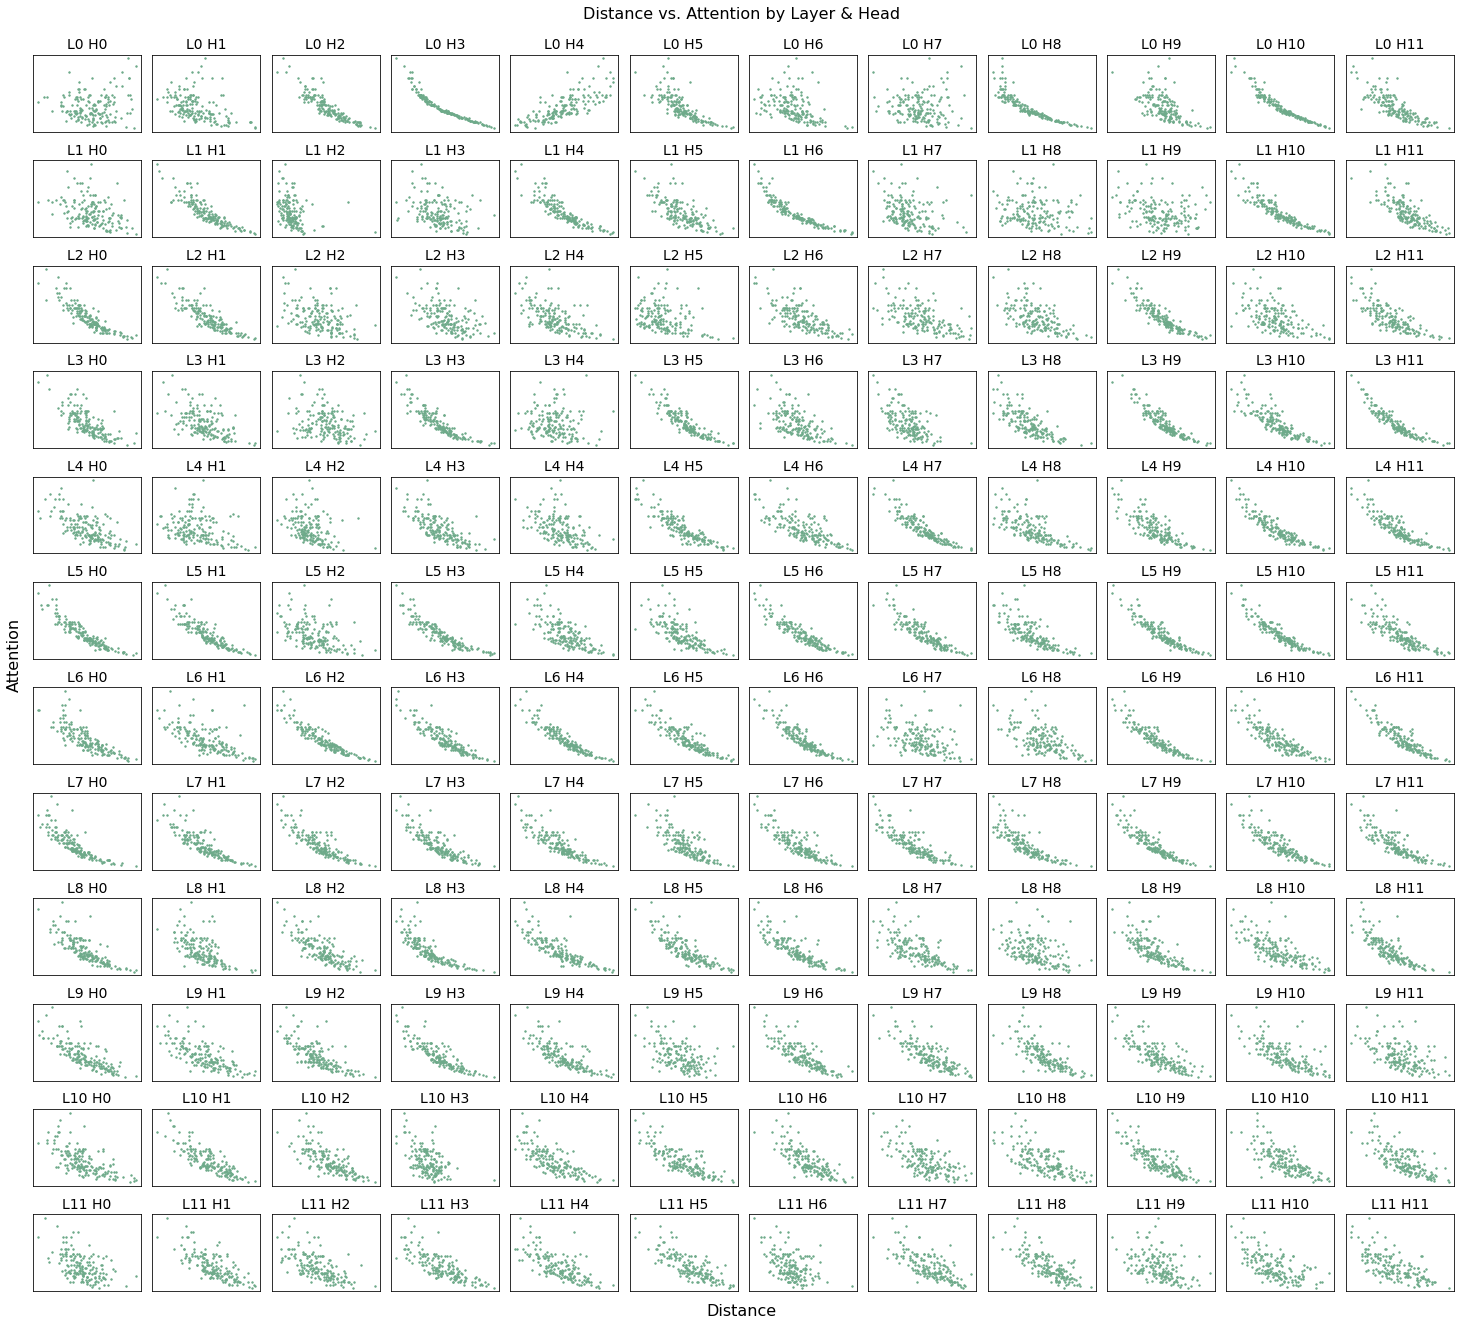

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# plt.scatter(overall_mean_d, overall_mean_a)
# plt.show()

fig, axs = plt.subplots(12, 12)

for layer in range(12):
    for head in range(12):
        ax = axs[layer, head]
        ax.scatter(sentence_mean_dists[layer * 12 + head], sentence_mean_attn[layer * 12 + head], s=2, c='#6EAA8A')
        ax.set_title("L{} H{}".format(layer, head), fontsize=14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.suptitle('Distance vs. Attention by Layer & Head', fontsize=16, y=1)
fig.set_size_inches(20, 18)
fig.tight_layout(pad=0.8)
fig.text(0.5, -0.01, 'Distance', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Attention', va='center', rotation='vertical', fontsize=16)
plt.show()


### heatmaps

In [12]:
# library
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [13]:
# compute offset for each sentence in dataset
tok_sentences = attn_dict["tokenized_sentences"]
num_sent = len(tok_sentences)

offset = 0
sent_offset = []
while offset < num_sent:
    sent_offset.append(offset)
    cur_sent = tok_sentences[offset]
    sent_length = len(cur_sent.split())
    offset += sent_length
    
print(len(sent_offset))

1000


In [14]:
# find sentences w/ highest and lowest correlations
def find_high_and_low(layer, head, mean_cor, tok_sentences, sent_offset):
    means = mean_cor[layer * 12 + head]
    
    means_and_ind = [[means[i], i] for i in range(len(means))]
    means_and_ind = sorted(means_and_ind)
    
    k = 2
    lowest = means_and_ind[-2:]
    highest = means_and_ind[:2]
    
#     for l in lowest:
#         offset = sent_offset[l[1]]
#         sent = tok_sentences[offset]
#         print(sent)
        
#     for h in highest:
#         offset = sent_offset[h[1]]
#         sent = tok_sentences[offset]
#         print(sent)
    return lowest + highest
    
print(find_high_and_low(10, 3, mean_cor, tok_sentences, sent_offset))

[[-0.9522144522144522, 120], [-0.9428904428904431, 44], [-0.9952399256839004, 84], [-0.995216645216645, 151]]


In [15]:
print(find_high_and_low(2, 10, mean_cor, tok_sentences, sent_offset))

[[-0.5850896508335957, 73], [-0.5576195390436877, 57], [-0.9395559876843299, 18], [-0.9351248332380403, 38]]


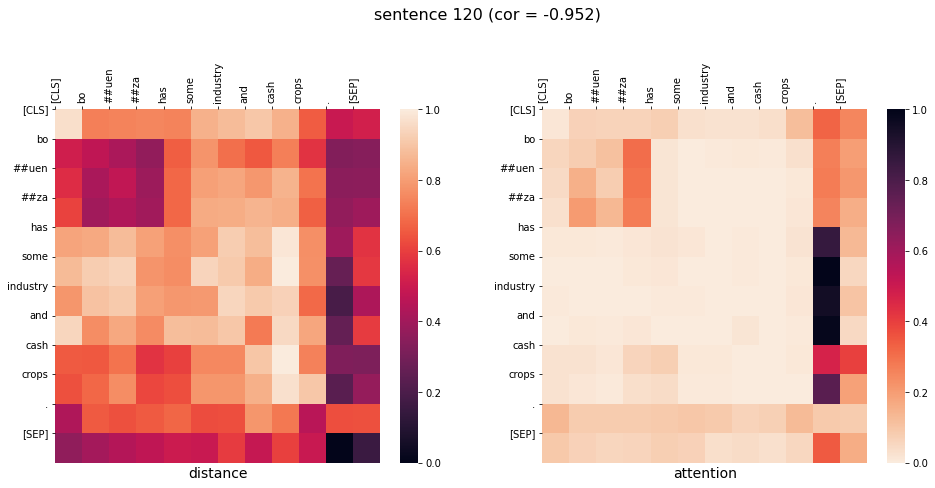

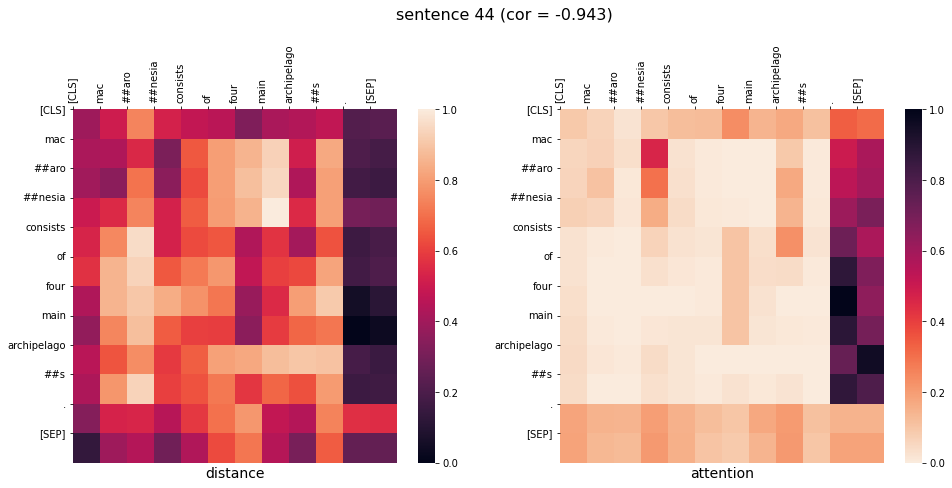

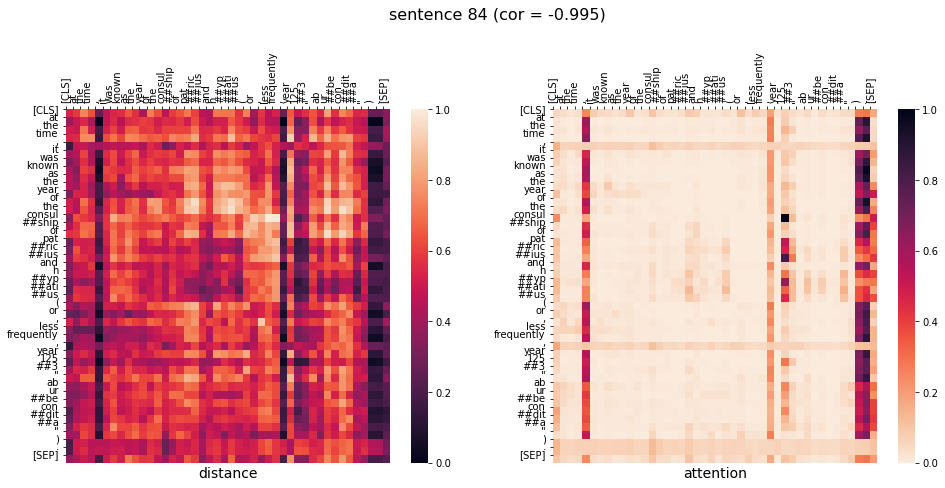

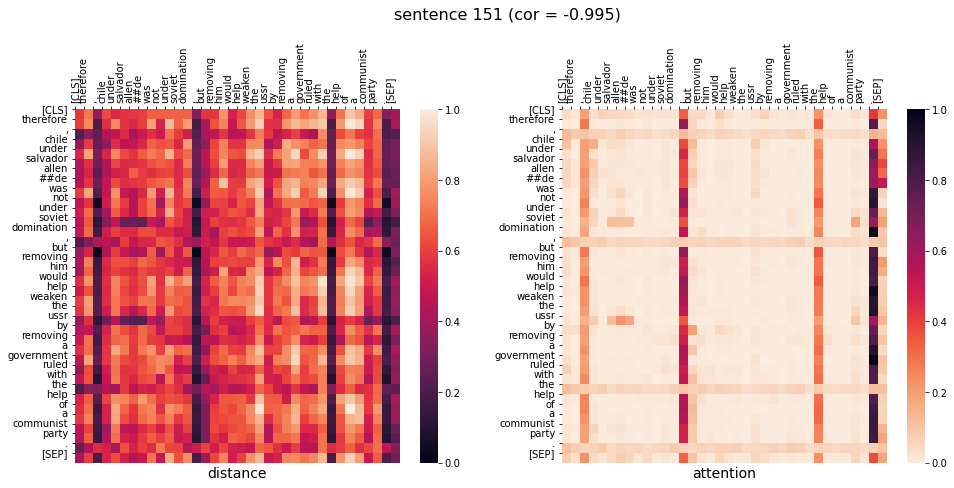

In [23]:
def make_heatmap(layer, head, distances, attention, mean_cor, sentences, sent_offset):
    d = distances[layer][head]
    a = attention[layer][head]
    
    res = find_high_and_low(layer, head, mean_cor, sentences, sent_offset)
    
    for r in res:
        i = r[1]
        c = r[0]
        offset = sent_offset[i]
        t = sentences[offset]
        
        sent_length = len(d[offset])
        dt = d[offset:offset+sent_length]
        at = a[offset:offset+sent_length]

        fig, axs = plt.subplots(ncols=2)
        fig.set_size_inches(16, 6.5)
        fig.suptitle('sentence {} (cor = {cor:.3f})'.format(i, cor=c), fontsize=16, y=1.1)

        sns.heatmap(dt, ax=axs[0])
        sns.heatmap(at, ax=axs[1], cmap = sns.cm.rocket_r)

        axs[0].set_xlabel('distance', fontsize=14)
        axs[0].set_xticks(range(sent_length), t.split(), rotation=90)
        axs[0].set_yticks(range(sent_length), t.split(), rotation=0)
        axs[0].xaxis.tick_top()

        axs[1].set_xlabel('attention', fontsize=14)
        axs[1].set_xticks(range(sent_length), t.split(), rotation=90)
        axs[1].set_yticks(range(sent_length), t.split(), rotation=0)
        axs[1].xaxis.tick_top()

make_heatmap(10, 3, distances, attention, mean_cor, tok_sentences, sent_offset)

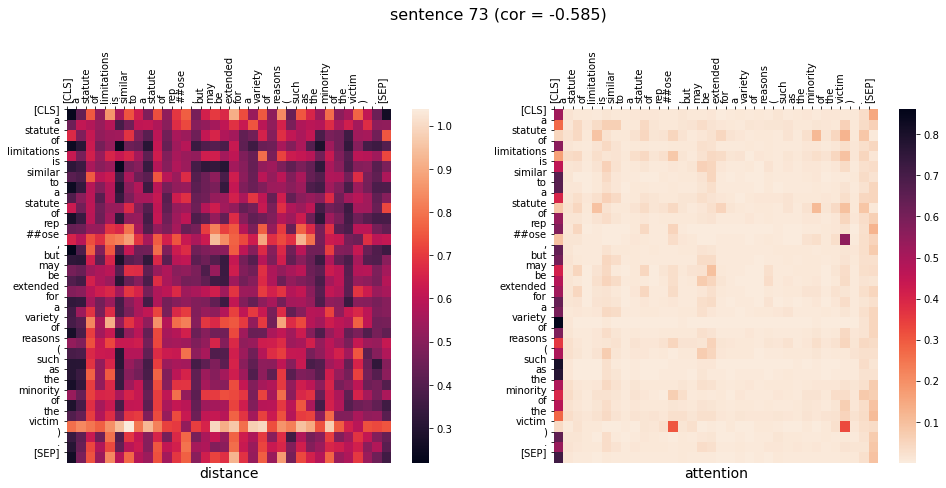

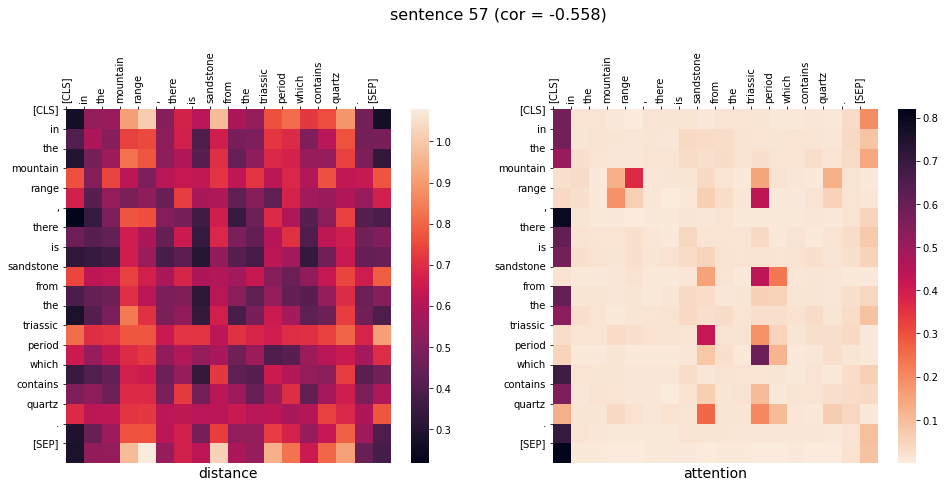

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38738 (\N{CJK UNIFIED IDEOGRAPH-9752}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26408 (\N{CJK UNIFIED IDEOGRAPH-6728}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


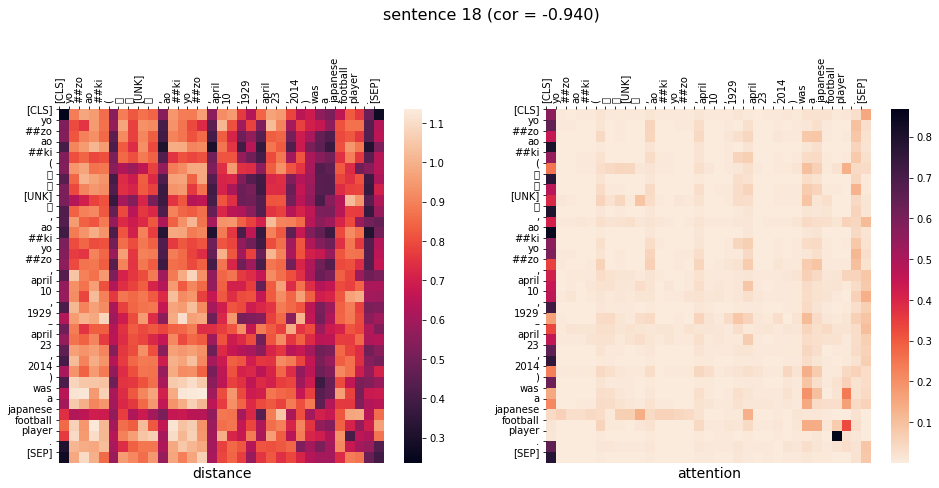

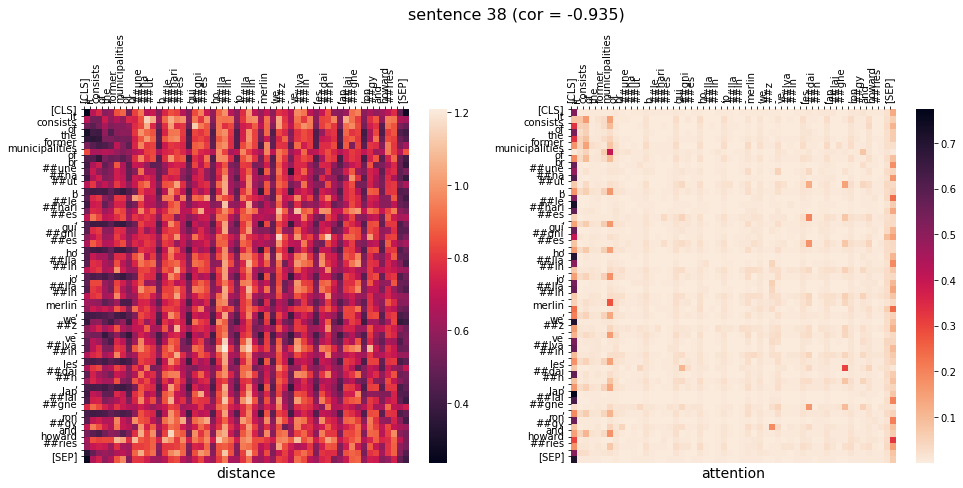

In [17]:
make_heatmap(2, 10, distances, attention, mean_cor, tok_sentences, sent_offset)

## Playing with TSNE / UMAP

Generating plots from query + key vectors

### installs

In [21]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 33.7 MB/s eta 0:00:0000:0100:01


In [14]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 3.0 MB/s eta 0:00:00a 0:00:01


In [38]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 23.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 19.9 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82814 sha256=169373e8bb5cb82e3bcac1d00b104fe854393ce62f49910cdc9da76058d80e00
  Stored in directory: /n/home10/cyeh/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54269 sha256=dc67c746d8ca0eb892487da0989f8bcfea79b492207d2462f55a243a553196e6
  Stored in directory: /n/home10/cyeh/.cache/pip/wheels/5b/f5/6e/aac11d69fe2115d9ac871d6c148b361f0d3f8a35ed7354fa03
Successful

### start code

In [32]:
# import
from sklearn.manifold import TSNE
from umap import UMAP
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# ensure plots show up in jupyter
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

In [34]:
import pickle
# load attn_dict back
attn_dict = pickle.load( open( "attn_dict.p", "rb" ) )

In [ ]:
# produce corresponding key matrix from query matrix (e.g., for attention)
def k_matrix(q_matrix):
    # assumes for specific layer + head (e.g., queries[0][0])
    num_tokens = len(q_matrix)
    k_matrix = []
    i = 0
    while i < num_tokens:
        q = q_matrix[i]
        sent_length = len(q)
        for k_i in range(sent_length):
            k = []
            for q_i in range(sent_length):
                k.append(q_matrix[q_i + i][k_i])
            k_matrix.append(k)
        i += sent_length
    
    return k_matrix
    
# res = k_matrix(attn_dict["attn"][0][0][:13])
# print(attn_dict["attn"][0][0][:13])
# print(res)
# print(len(res))
# print(len(res[0]))

In [ ]:
#layer = 0
#head = 0

def fix_sentences(sentences, positions, types):
    # format sentences to be displayed in html plot
    new_sentences = []
    for sent, pos, t in zip(sentences, positions, types):
        s_arr = sent.split()
        s = ""
        for i in range(len(s_arr)):
            if i % 10 == 0 and i not in [0, len(s_arr) - 1]:
                s += "<br>" # add new line every 10 tokens
                
            if i == pos: # italicize  + color current token
                color = "#B6E1B9"
                if t == "key":
                    color = "#F6BA98"
                s += "<b style='color:" + color + "'>" + s_arr[i] + "</b>"
            else:
                s += s_arr[i]
                
            if s != len(s_arr) - 1:
                s += " " # add space back between each token
        new_sentences.append(s)
    
    return new_sentences

def make_df(layer, head):
# convert data into pandas dataframe
    df = pd.DataFrame()
    df['token'] = attn_dict['left_text'] + attn_dict['right_text'] # store tokens
    df['token'] = df['token'].str.lower() # convert to lowercase
    num_tokens = len(attn_dict['left_text'])
    
    df['type'] = ['query'] * num_tokens + ['key'] * num_tokens # store token type
    df['pos_int'] = attn_dict['positions'] * 2 # positions
    df['position'] = attn_dict['normalized_positions'] * 2
    
    # sentence itself
    df['sentence'] = fix_sentences(attn_dict['tokenized_sentences'], attn_dict['positions'], df['type'][:num_tokens]) + fix_sentences(attn_dict['tokenized_sentences'], attn_dict['positions'], df['type'][num_tokens:])

    # save attn info
    attn = attn_dict['attn'][layer][head]
    df['attn'] = attn + k_matrix(attn)
    #df['max_ind'] = [a.index(max(a)) for a in df['attn']]
    dp = attn_dict['dot_prod'][layer][head]
    df['dot_prod'] = dp + k_matrix(dp)
    
    # extract q/k vectors
    queries = attn_dict['queries']
    keys = attn_dict['keys']
    # queries = new_queries
    # keys = new_keys
    vec_size = len(queries[layer][head][0])
    
    # norms
    norms_q = []
    norms_k = []
    for i in range(len(queries[layer][head])):
        q = queries[layer][head][i]
        k = keys[layer][head][i]
        norms_q.append(np.linalg.norm(q))
        norms_k.append(np.linalg.norm(k))
    df["norm"] = norms_q + norms_k
    
    # df = pd.concat([df.iloc[:5021], df.iloc[30070:30070+5021]]) # only get first X keys + queries

    for i in range(vec_size): # store q/k vector values
        qs = [queries[layer][head][j][i] for j in range(num_tokens)]
        ks = [keys[layer][head][j][i] for j in range(num_tokens)]
        df["f" + str(i)] = qs + ks # add to dataframe
        
    # comment out line below if want all 60k data points
    df = pd.concat([df.iloc[:5021], df.iloc[30070:30070+5021]]) # only get first X keys + queries
    # df = pd.concat([df.iloc[:5024], df.iloc[30085:30085+5024]]) # only get first X keys + queries
    # print(len(df))
    # df_lab = df.iloc[:, :8].copy() # get label cols only
    df.to_csv('test.tsv', sep="\t", index=False)
    # df_lab.to_csv('layer' + str(layer) + '/labels' + str(head) + '.tsv', sep="\t", index=False) # save labels to file
    
    return df

# testing
df = make_df(0, 0)
df.tail()

,token,type,pos_int,position,sentence,attn,dot_prod,norm,f0,f1,...,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63
35086,sub,key,26,0.866667,"[CLS] kangaroo ##s , wall ##abi ##es and allie...","[0.04446050524711609, 0.029005035758018494, 0....","[4.107474327613763, 12.25144527392831, 12.7672...",6.215179,-0.448427,0.452015,...,0.025935,-0.252371,-0.307189,-0.553393,-0.400281,-0.044767,-0.931861,0.024397,0.395096,-0.427139
35087,##ord,key,27,0.900000,"[CLS] kangaroo ##s , wall ##abi ##es and allie...","[0.017383454367518425, 0.031417425721883774, 0...","[-3.405184217087513, 12.890593100794, 16.50026...",6.301130,0.534106,0.985070,...,0.437646,-0.070235,-0.187653,0.003272,-0.369582,-0.121824,-1.577264,-0.691520,0.792727,-0.869315
35088,##er,key,28,0.933333,"[CLS] kangaroo ##s , wall ##abi ##es and allie...","[0.018225491046905518, 0.03727560117840767, 0....","[-3.026765633419176, 14.258397435895029, 13.91...",6.985735,-0.406283,1.448743,...,-0.780940,-0.496483,-0.708584,0.035365,-0.862425,-0.592727,-1.774222,-0.381993,1.461982,-0.028197
35089,.,key,29,0.966667,"[CLS] kangaroo ##s , wall ##abi ##es and allie...","[0.043427273631095886, 0.01755058579146862, 0....","[3.919364389099087, 8.23238790475757, 9.135531...",7.528353,-0.333451,0.357409,...,-0.096163,1.146897,-0.553073,0.408580,0.232851,0.218227,-0.417159,-0.883505,0.674915,-0.970439
35090,[sep],key,30,1.000000,"[CLS] kangaroo ##s , wall ##abi ##es and allie...","[0.11081883311271667, 0.028564557433128357, 0....","[11.413837310144922, 12.129022273708411, 16.45...",8.919486,-0.882669,1.418840,...,-0.142821,-1.192498,0.476258,-0.628260,0.349613,0.775241,-0.985531,-0.338950,0.189099,0.347325


In [100]:
def save_norms():
# convert data into pandas dataframe
    df = pd.DataFrame()
    
    # extract q/k vectors
    queries = attn_dict['queries']
    keys = attn_dict['keys']
    vec_size = len(queries[0][0][0])
    
    for layer in range(12):
        for head in range(12):
            # norms
            norms_q = []
            norms_k = []
            for i in range(len(queries[layer][head])):
                q = queries[layer][head][i]
                k = keys[layer][head][i]
                norms_q.append(np.linalg.norm(q))
                norms_k.append(np.linalg.norm(k))
            df["layer{}_head{}".format(layer, head)] = norms_q + norms_k
    
    df = pd.concat([df.iloc[:5021], df.iloc[30070:30070+5021]]) # only get first X keys + queries
    df.to_csv('test.csv', index=False)

# testing
save_norms()

<ipython-input-100-addc1e7a1e26>:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-100-addc1e7a1e26>:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-100-addc1e7a1e26>:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-100-addc1e7a1e26>:20: PerformanceWarn

### translating key vectors
Translate keys to have same centroid as queries for easier(?) comparison

In [ ]:
def find_q_means(df):
    # find mean of each feature in query embeddings
    df_queries = df.loc[df['type'] == 'query']
    df_queries = df_queries.iloc[:, 8:].copy()
    # df_queries.head()
    query_means = df_queries.mean(axis=0)
    return query_means

# query_means = find_q_means(df)
# query_means

In [56]:
def find_k_means(df):
    # find mean of each feature in key embeddings
    df_keys = df.loc[df['type'] == 'key']
    df_keys = df_keys.iloc[:, 8:].copy()
    # df_keys.head()
    key_means = df_keys.mean(axis=0)
    # key_means
    return df_keys, key_means

# df_keys, key_means = find_k_means(df)
# key_means

In [57]:
def translate_keys(df, df_keys, query_means, key_means):
# translate key vectors accordingly
    # new_keys = pd.DataFrame()
    for i in range(64):
        col = "f" + str(i)
        new_key = df_keys[col] - key_means[col] + query_means[col]
        df.loc[df['type'] == 'key', col] = new_key

    # print(new_keys.head())
    # new_means = df[df.type == 'key'].mean(axis=0)
    # print(new_means)
    # df.tail()
    return df

# df = translate_keys(df, df_keys, query_means, key_means)

In [92]:
# whole translation loop
def translate_loop(df): 
    query_means = find_q_means(df)
    df_keys, key_means = find_k_means(df)
    df = translate_keys(df, df_keys, query_means, key_means)
    return df

df = translate_loop(df)
df.tail()

,token,type,pos_int,position,sentence,attn,dot_prod,norm,f0,f1,...,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63
35086,sub,key,26,0.866667,"[CLS] kangaroo ##s , wall ##abi ##es and allie...","[0.17691506445407867, 0.0025444836355745792, 0...","[24.38800987728303, 1.5690075641437866, 13.460...",9.294872,0.100511,0.217099,...,0.041817,0.165159,-0.339815,0.400246,0.068378,-0.038096,-0.474063,-0.557412,-0.341752,0.485353
35087,##ord,key,27,0.900000,"[CLS] kangaroo ##s , wall ##abi ##es and allie...","[0.19362607598304749, 0.012384094297885895, 0....","[25.11008716337695, 14.22888451323643, 32.1977...",9.402184,-0.474798,0.428881,...,0.035775,-0.006251,0.050368,0.475384,-0.231639,-0.232532,-0.262168,0.111336,-0.591065,0.691080
35088,##er,key,28,0.933333,"[CLS] kangaroo ##s , wall ##abi ##es and allie...","[0.08552932739257812, 0.0029389469418674707, 0...","[18.573526962579628, 2.721991629879322, 20.115...",8.941825,-0.585019,0.237344,...,-0.043405,-0.244104,0.119698,0.334778,-0.174573,-0.130198,-0.142514,-0.349686,-0.324401,0.862859
35089,.,key,29,0.966667,"[CLS] kangaroo ##s , wall ##abi ##es and allie...","[0.02343020774424076, 0.02943713590502739, 0.0...","[8.214866969622722, 21.155639266643004, 22.101...",7.049569,-0.490751,0.410779,...,0.308306,0.198165,0.135933,0.215266,-0.158954,0.042688,-0.170217,0.351525,-0.310823,0.698593
35090,[sep],key,30,1.000000,"[CLS] kangaroo ##s , wall ##abi ##es and allie...","[0.037670236080884933, 0.1813211739063263, 0.0...","[12.013620541114975, 35.69974067693014, 26.047...",7.909104,-0.386050,0.485831,...,0.216367,0.156627,0.212257,0.197244,-0.197666,0.271856,-0.359025,0.359142,-0.263533,0.449323


In [ ]:
df.to_csv('test.csv', index=False)

### subtracting position

In [66]:
def subtract_pos(df, layer, head, all_embeddings):
    resids = get_residual(layer, head, all_embeddings)
    for p in range(len(pos_embeddings)):
        for i in range(64):
            # col = "f" + str(i)
            df.iloc[p, 8 + i] -= resids[p][i] - pos_embeddings[p][i]
    
    return df
   
# df = subtract_pos(df, 3, 3, all_embeddings)
# df.tail()

### plot generation

In [ ]:
# load existing data
tsne_results = np.load("tsne/translated_layer0_head0.npy")
# umap_results = np.load("umap/layer0_head0.npy")

In [93]:
# run TSNE
def run_tsne(df, layer, head):
    # prepare data for feature plot
    df_sub = df.iloc[:, 8:].copy()
    df_subset = df_sub.values # only get feature cols
    #df_sub.to_csv('layer' + str(layer) + '/features' + str(head) + '.tsv', sep="\t", index=False, header=False) # save feature data
    
    # run TSNE
    # from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    time_start = time.time()
    # tsne = TSNE(n_components=3, verbose=0, perplexity=100, n_iter=300) # 3D
    tsne = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=300, metric="cosine") # 2D
    tsne_results = tsne.fit_transform(df_subset)
    # np.save("tsne/nopos_layer" + str(layer) + "_head" + str(head) + ".npy", tsne_results) # save tsne results too
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results

tsne_results = run_tsne(df, 9, 8)

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 18.452030658721924 seconds


In [94]:
def run_umap(df, layer, head):
    # prepare data for feature plot
    df_sub = df.iloc[:, 8:].copy()
    df_subset = df_sub.values # only get feature cols
    #df_sub.to_csv('layer' + str(layer) + '/features' + str(head) + '.tsv', sep="\t", index=False, header=False) # save feature data
    
    # run umap
    time_start = time.time()
    umap = UMAP(n_components=2, init='random', random_state=0, metric="cosine")
    umap_results = umap.fit_transform(df_subset)
    # np.save("umap/nopos_layer" + str(layer) + "_head" + str(head) + ".npy", umap_results) # save umap results too
    print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return umap_results

umap_results = run_umap(df, 9, 8)

UMAP done! Time elapsed: 8.896152973175049 seconds


In [61]:
# save variable for later computation
half = int(len(tsne_results) / 2)
print(half)

5021


In [62]:
# add additional columns to df
def add_to_df(df):
    # positions (not normalized)
    df['pos_int'] = attn_dict['positions'][:half] * 2
    # df['pos_int'] = attn_dict['positions'] * 2
    df['pos_int'] = df['pos_int'] + 1
    #print(df['pos_int'].head(20))
    
    # length of sentence
    words = df['sentence'].str.split().str.len()
    df['length'] = words
    # print(df['length'].head(20))
    # print(len(df['length']))
    
    # corresponding color for queries/keys
    colors = []
    for t in df['type']:
        if t == "query":
            colors.append("#B6E1B9")
        else:
            colors.append("#F6BA98")

    # print(colors[:20])
    df['color'] = colors
    df['norm'] = round(df['norm'], 2)

    return df

In [63]:
def make_fig(tsne_results, df, layer, head, plot_type):
    # plot TSNE / UMAP results with plotly
    # 3D version
    # fig = px.scatter_3d(
    #     tsne_results[half:], x=0, y=1, z=2,
    #     color=df.norm[half:], labels={'color': 'normalized position'}, color_continuous_scale=px.colors.sequential.Burgyl,
    #     title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
    #     height=800,
    #     opacity=0.5
    # )
    
    # 2D version
    fig = px.scatter(
        tsne_results[half:], x=0, y=1,
        color=df.position[half:], labels={'color': 'normalized position'}, color_continuous_scale=px.colors.sequential.Burgyl,
        title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
        height=800,
        opacity=0.5
    )
    fig2 = px.scatter(
        tsne_results[:half], x=0, y=1, 
        color=df.position[:half], labels={'color': ''}, color_continuous_scale=px.colors.sequential.Blugrn,
        title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
        height=800,
        opacity=0.5
    )
    
    # add second trace to include 2 color scales (1st is key, 2nd is query)
    fig.layout.coloraxis2 = fig2.layout.coloraxis
    fig.add_trace(fig2.data[0])
    fig['data'][1]['marker'] = {    'color' : df['position'][:half],
                                    'coloraxis' : 'coloraxis2',
                                    'opacity' : 0.5
                                }
    # formatting things
    fig.layout.coloraxis.colorbar.x = 1.05
    fig.layout.coloraxis.colorbar.title.side = "right"
    fig.layout.coloraxis2.colorbar.x = 1.01
    fig.layout.coloraxis2.colorbar.ticklabelstep=70
    fig.layout.coloraxis2.colorbar.ticklabelposition="inside"
    
    # updating display
    fig.update_traces( # queries
        customdata=df[['token', 'sentence', 'pos_int', 'length', 'type', 'color', 'norm']][:half],
        hovertemplate="<b style='font-size:larger'><span style='color:%{customdata[5]}'>%{customdata[0]}</span> (<i>%{customdata[4]}</i>, pos: %{customdata[2]} of %{customdata[3]}, norm: %{customdata[6]})</b><br><br>%{customdata[1]}",
        selector=dict(marker_coloraxis='coloraxis2'),
        marker=dict(size=6)
    )
    fig.update_traces( # keys
        customdata=df[['token', 'sentence', 'pos_int', 'length', 'type', 'color', 'norm']][half:],
        hovertemplate="<b style='font-size:larger'><span style='color:%{customdata[5]}'>%{customdata[0]}</span> (<i>%{customdata[4]}</i>, pos: %{customdata[2]} of %{customdata[3]}, norm: %{customdata[6]})</b><br><br>%{customdata[1]}",
        selector=dict(marker_coloraxis='coloraxis'),
        marker=dict(size=6)
    )
    fig.update_layout(
        plot_bgcolor='#E8E8E8',
        hoverlabel=dict(font_color = 'white', bordercolor = 'white'),
    )
    
    # save plot as html file
    fig.write_html(plot_type + "_plots/layer" + str(layer) + "_head" + str(head) + ".html")
    fig.show()
    
# make_fig(tsne_results, df, 0, 0, "TSNE")

In [95]:
# make 1 TSNE plot w/ pre-loaded data
df = add_to_df(df)
make_fig(tsne_results, df, 9, 8, "TSNE")

In [96]:
# make 1 UMAP plot w/ pre-loaded data
# df = add_to_df(df)
make_fig(umap_results, df, 9, 8, "UMAP")

In [34]:
# generate tsne plot for specific layer, head of BERT
def generate_tsne(layer, head):
    df = make_df(layer, head)
    df = translate_loop(df)
    tsne_results = run_tsne(df, layer, head)
    df = add_to_df(df)
    make_fig(tsne_results, df, layer, head, "TSNE")

In [ ]:
generate_tsne(3, 11)

In [35]:
# generate umap plot for specific layer, head of BERT
def generate_umap(layer, head):
    df = make_df(layer, head)
    df = translate_loop(df)
    umap_results = run_umap(df, layer, head)
    df = add_to_df(df)
    make_fig(umap_results, df, layer, head, "UMAP")

In [65]:
generate_umap(0, 0)

UMAP done! Time elapsed: 102.68756198883057 seconds


In [53]:
# generate tsne/umap simultaneously
def generate_tsne_and_umap(layer, head):
    df = make_df(layer, head)
    df = translate_loop(df)
    # df = subtract_pos(df, layer, head, all_embeddings)
    tsne_results = run_tsne(df, layer, head)
    umap_results = run_umap(df, layer, head)
    df = add_to_df(df)
    make_fig(tsne_results, df, layer, head, "TSNE")
    make_fig(umap_results, df, layer, head, "UMAP")

In [57]:
generate_tsne_and_umap(11, 3)

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done! Time elapsed: 53.19543719291687 seconds
UMAP done! Time elapsed: 9.808901309967041 seconds


In [ ]:
# loop for generating plots
for i in range(6):
    for j in range(12):
        generate_tsne_and_umap(i, j)
        print("Layer {} Head {} done".format(i, j))

### extracting colors

In [6]:
from plotly.colors import colorscale_to_scale
import plotly.express as px

rgb_values = colorscale_to_scale(px.colors.sequential.Burgyl)
print(rgb_values)

['r', 'r', 'r', 'r', 'r', 'r', 'r']


### saving coordinates

In [7]:
def convert_to_str(layer, head):
    umap_str = ""
    file = "umap_coords/layer" + str(layer) + "_head" + str(head) + ".txt"
    umap_results = np.load("umap/layer" + str(layer) + "_head" + str(head) + ".npy")
    x = [i[0] for i in umap_results]
    y = [i[1] for i in umap_results]
    
    half = int(len(x) / 2)

    x1_str = '"x":' + str(x[:half])
    y1_str = '"y":' + str(y[:half])
    x2_str = '"x":' + str(x[half:])
    y2_str = '"y":' + str(y[half:])
    
    umap_str = x1_str + "\n" + y1_str + "\n" + x2_str + "\n" + y2_str
    
    with open(file, 'w') as o:
        o.write(umap_str)
    
convert_to_str(0, 0)

In [8]:
for i in range(12):
    for j in range(12):
        convert_to_str(i, j)

### distance archive
Here, I was trying to compute distances between tokens to color points in the plot, but it didn't end up being very informative :).

In [47]:
q_distances = np.load("distances/q_dist.npy")
k_distances = np.load("distances/k_dist.npy")

In [48]:
# normalizing distances
def normalize(data):
    min_val = min(data)
    #print(min_val)
    max_val = max(data)
    #print(max_val)
    range_val = max_val - min_val
    
    return [(i - min_val) / range_val for i in data]

#print(q_distances[:20])
q_dist_norm = normalize(q_distances)
#print(k_distances[:20])
k_dist_norm = normalize(k_distances)

#print(q_dist_norm[:20])
#print(k_dist_norm[:20])

all_dist = q_dist_norm + k_dist_norm
all_dist = [min(1.1 - i, 1) for i in all_dist]
print(all_dist[:20])
print(min(all_dist))
print(max(all_dist))

[0.10000000000000009, 0.7964809766550964, 0.8340010718065826, 0.8521522066513654, 0.5921681533586152, 0.822153149740546, 0.7328068950021316, 0.9392737348801551, 0.6976148314431625, 0.6590652740617418, 0.8272453501019104, 0.6675960574652788, 0.5040552632433122, 0.4051076203744457, 0.7576204764039469, 0.8948855264973727, 0.7769217196500395, 0.7657748950806385, 0.7122411742619081, 0.9270220895690945]
0.10000000000000009
1


In [ ]:
from scipy.spatial import distance

queries = attn_dict['queries'][0][0]
keys = attn_dict['keys'][0][0]
half = len(queries)

# q_distances = [0] * half  # query to key
# k_distances = [0] * half # key to query
# q_distances = np.load("distances/q_dist16299.npy")
# k_distances = np.load("distances/k_dist16299.npy")
saved_pairs = {}

# find min cosine distance for each point to other group
for i in range(half):
    # q_min = q_distances[i]
    for j in range(half):
        # k_min = k_distances[j]
        # if (i,j) in saved_pairs: # check if already computed
        #     d = saved_pairs[(i,j)]
        # elif (j,i) in saved_pairs:
        #     d = saved_pairs[(j,i)]
        # else: # otherwise, compute and save
        if (i,j) not in saved_pairs and (j,i) not in saved_pairs:
            d = distance.cosine(queries[i], keys[j])
            saved_pairs[(i,j)] = d
        
        # if q_min == 0 or d < q_min: # new min distance found for query
        #     q_min = d
        # if k_min == 0 or d < k_min:
        #     k_distances[j] = d # update min distance for key
            
#     q_distances[i] = q_min # store min distance for each query
    
#     if (i+1) % 100 == 0: # save incrementally
#         np.save("distances/q_dist" + str(i) + ".npy", q_distances)
#         np.save("distances/k_dist" + str(i) + ".npy", k_distances)

In [6]:
np.save("distances/q_dist.npy", q_distances)
np.save("distances/k_dist.npy", k_distances)

In [ ]:
num_pairs = len(saved_pairs)

start = 0
while start < num_pairs:
    end = min(start + 10000000, num_pairs)
    
    with open('pair_dist' + str(end) + '.p', 'wb') as file:
        pickle.dump(saved_pairs[start:end], file, protocol=pickle.HIGHEST_PROTOCOL)
    
    start = end

In [7]:
# compute distances for each point
def distance_to_op(types, coords):
    saved_pairs = {} # keep track of already computed distances
    distances = {} # store all distances
    
    
    half = int(len(coords) / 2) # half of points are queries, other half are keys
    for i in range(half):
        c = coords[i] # current point
        x0 = c[0]
        y0 = c[1]
        t = types[i] # type of current point
        
        # find how far point is from one of the other color
        dists = []
        start = 0 # search queries
        if t == "query": # search keys
            start = half
        
        distances[i] = [] # new list of distances for each point
        for j in range(start, start + half):
            x1 = coords[j,0]
            y1 = coords[j,1]
            if ((x0,y0),(x1,y1)) in saved_pairs: # check if already computed
                d = saved_pairs[((x0,y0),(x1,y1))]
            elif ((x1,y1),(x0,y0)) in saved_pairs:
                d = saved_pairs[((x1,y1),(x0,y0))]
            else: # otherwise, compute and save
                d = (x1-x0)**2 + (y1-y0)**2
                saved_pairs[((x0,y0),(x1,y1))] = d
                
            distances[i].append([d,j])
        
        # sort neighbors by distance
        ds_sorted = sorted(distances[i], key=lambda item: item[0])
        distances[i] = ds_sorted
        
        if i + 1 % 100 == 0:
            with open('distances/distance' + str(i+1) + '.p', 'wb') as file:
                pickle.dump(distances, file, protocol=pickle.HIGHEST_PROTOCOL)
            distances = {}
            print("{} points done".format(i+1))
        
    return distances

In [ ]:
distances1 = distance_to_op(df['type'], tsne_results)

# save distances to pickle file
with open('distances.p', 'wb') as file:
    pickle.dump(distances, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# compute distances for each point
def distance_to_op2(types, coords):
    saved_pairs = {} # keep track of already computed distances
    distances = {} # store all distances
    
    
    half = int(len(coords) / 2) # half of points are queries, other half are keys
    for i in range(half, len(coords)):
        c = coords[i] # current point
        x0 = c[0]
        y0 = c[1]
        t = types[i] # type of current point
        
        # find how far point is from one of the other color
        dists = []
        start = 0 # search queries
        if t == "query": # search keys
            start = half
        
        distances[i] = [] # new list of distances for each point
        for j in range(start, start + half):
            x1 = coords[j,0]
            y1 = coords[j,1]
            if ((x0,y0),(x1,y1)) in saved_pairs: # check if already computed
                d = saved_pairs[((x0,y0),(x1,y1))]
            elif ((x1,y1),(x0,y0)) in saved_pairs:
                d = saved_pairs[((x1,y1),(x0,y0))]
            else: # otherwise, compute and save
                d = (x1-x0)**2 + (y1-y0)**2
                saved_pairs[((x0,y0),(x1,y1))] = d
                
            distances[i].append([d,j])
        
        # sort neighbors by distance
        ds_sorted = sorted(distances[i], key=lambda item: item[0])
        distances[i] = ds_sorted
        
    return distances

In [ ]:
distances2 = distance_to_op2(df['type'], tsne_results)

In [145]:
# generate list of closest distance for each point
closest = [distances[i][0][0] for i in distances]
min_dist = min(closest)
max_dist = max(closest)
range_dist = max_dist - min_dist

# normalize distances
closest = [(i - min_dist) / range_dist for i in closest]

print(closest)

[0.0, 0.00010087566984879346, 0.005651248173563564, 0.004912073054966907, 0.836307155004952, 0.005302461048676023, 0.09656457194305487, 0.013587895642878938, 0.40035429452513677, 1.0]


### archive

In [45]:
# STATS
words = df['sentence'].str.split().str.len()
avg = words.mean() # average number of tokens per sentence
mx = words.max() # max number of tokens per sentence
mn = words.min() # min number of tokens per sentence

print("mean: {}, max: {}, min: {}".format(avg, mx, mn))

mean: 38.402593947455934, max: 100, min: 8


In [ ]:
import string
def lighten_special_tokens(tokens):
    # make special tokens/punctuation parks more transparent
    opacity = []
    for t in tokens:
        if t in ['[CLS]', '[SEP]'] or t in string.punctuation:
            opacity.append(0.5)
        else:
            opacity.append(1)
    return opacity

In [95]:
print(tsne_results)
print(tsne_results[0, 1])
#np.save("tsne/layer" + str(0) + "_head" + str(0) + ".npy", tsne_results)

[[ 6.8626175  -2.5363183 ]
 [-0.93323946 -0.8524197 ]
 [ 0.8479033  -0.38534203]
 ...
 [ 5.8986435   0.07962178]
 [-4.391037    4.51485   ]
 [-2.2338152   6.0144286 ]]
-2.5363183


In [42]:
res = np.load("tsne/layer" + str(0) + "_head" + str(0) + ".npy")
print(res)

[[ 6.8626175  -2.5363183 ]
 [-0.93323946 -0.8524197 ]
 [ 0.8479033  -0.38534203]
 ...
 [ 5.8986435   0.07962178]
 [-4.391037    4.51485   ]
 [-2.2338152   6.0144286 ]]


In [24]:
# double check
#queries[layer][head][0]
#keys[layer][head][0]

In [17]:
# prepare data for feature plot
df_sub = df.iloc[:, 2:].copy()
df_subset = df_sub.values # only get feature cols
df_subset

array([[ 0.70898962, -0.15323275, -0.03238618, ..., -0.18608412,
        -1.18974149, -0.39165065],
       [ 0.21045113,  0.10722202,  0.70467222, ...,  0.12194056,
        -0.04383624, -0.2158055 ],
       [ 1.11961699, -0.93376064,  0.32028458, ...,  0.57198089,
        -1.03599632,  0.42533043],
       ...,
       [-0.61514747,  0.02714804,  0.16023751, ...,  0.53608024,
         0.21529379, -0.6866461 ],
       [-0.46312889,  0.49632475, -0.23232232, ..., -1.12989068,
         0.45554301, -0.71385676],
       [-1.13201749,  1.45063257, -0.11892767, ..., -0.61138368,
         0.1281762 ,  0.50006604]])

In [47]:
df_lab = df.iloc[:, :2].copy() # get label cols only
df_lab.head()

,token,type
0,[CLS],query
1,synth,query
2,##pop,query
3,band,query
4,freeze,query


In [14]:
df_sub.to_csv('features' + str(head) + '.tsv', sep="\t", index=False, header=False) # save feature data

In [44]:
df_lab.to_csv('labels.tsv', sep="\t", index=False) # save label data

In [48]:
# run TSNE
# from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsne_results = tsne.fit_transform(df_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2aff932a2ee0>
Traceback (most recent call last):
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/n/home10/cyeh/anaconda3/envs/dif

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 60140 samples in 0.011s...
[t-SNE] Computed neighbors for 60140 samples in 24.969s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60140
[t-SNE] Computed conditional probabilities for sample 2000 / 60140
[t-SNE] Computed conditional probabilities for sample 3000 / 60140
[t-SNE] Computed conditional probabilities for sample 4000 / 60140
[t-SNE] Computed conditional probabilities for sample 5000 / 60140
[t-SNE] Computed conditional probabilities for sample 6000 / 60140
[t-SNE] Computed conditional probabilities for sample 7000 / 60140
[t-SNE] Computed conditional probabilities for sample 8000 / 60140
[t-SNE] Computed conditional probabilities for sample 9000 / 60140
[t-SNE] Computed conditional probabilities for sample 10000 / 60140
[t-SNE] Computed conditional probabilities for sample 11000 / 60140
[t-SNE] Computed conditional probabilities for sample 12000 / 60140
[t-SNE] Computed conditional probabilities for s

In [45]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="type",
#     palette=sns.color_palette("hls", 2),
#     data=df,
#     legend="full",
#     alpha=0.8
# )
# plt.title("TSNE Plot for Bert (Layer 0, Attention Head 0)")
# for i, label in enumerate(df['token']):
#     plt.annotate(label, (df['tsne-2d-one'][i] - 3, df['tsne-2d-two'][i] + 2))

Text(0.5, 1.0, 'TSNE Plot for Bert (Layer 0, Attention Head 0)')

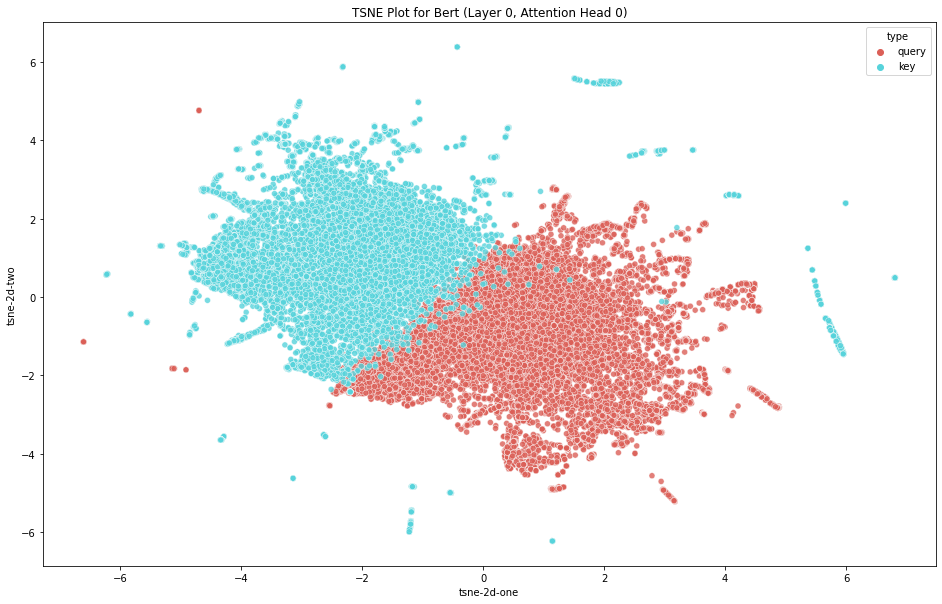

In [39]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="type",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.8
)
plt.title("TSNE Plot for Bert (Layer 0, Attention Head " + str(head) + ")")